In [1]:
import pandas as pd
import numpy as np
import datetime 
from datetime import timedelta

from scipy import stats as st

import warnings
warnings.filterwarnings(action='ignore')

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import math as mth
import colorama
from colorama import Style
from colorama import Fore

import retentioneering

# Выделение групп пользователей приложения "Ненужные вещи" на основе поведения

## Декомпозиция

1. В рамках исследовательского анализа данных смотрим на распределение данных по времени. Устанавливаем, зависит и как зависит активность пользователей в целом от дня недели. **Рассчитываем поля, необходимые для разбиения пользователей на группы. В частности даты начала сессий, число сессий, длительность сессий, число событий, частотоность событий, общее время в приложении и среднее время между целевыми событиями**.

2. На основании выведенных данных проводим кластеризацию пользователей. **Выделяем 4-5 групп (слишком большое количество групп может затруднить анализ из-за стравнительно низкого размера группы**.

3. По каждой группе рассчитываем целевые метрики. Retention rate на 14-й день (покупка б/у-вещей не является сервисом высокой частоты использования, поэтому недельный лайфтайм может быть слишком мал для фиксирования положения дел, а трехнедельный лайфтайм слишком велик, потому что у нас данные за один месяц и мы должны будем исключить из анализа три четверти данных, так как они "не дожили" до необходимого лайфтайма). Также расчитываем по группам общее время в приложении, частоту совершения событий (число событий в час) и конверсию в целевое событие contacts_show. 

4. Визуализируем полученные данные по кластерам и **анализируем, пользователи какой группы отличаются высоким retention rate на 14-й день, чаще пользуются приложением, какая группа лидирует по числу целевых действий и конверсии в него, как отличаются интервалы времени между основными событиями по группам**.

5. Формулируем гипотезы. 

Н0: Конверсии в целоевое действие у пользователей, привлеченных с площадок yandex и google не отличаются.

Н1: Конверсии в целоевое действие у пользователей, привлеченных с площадок yandex и google отличаются.

Н0: Конверсии в целоевое действие у пользователей из группы с максимальным временем, проведенным в приложении, и у группы с минимальным временем, проведенным в приложении не отличаются.

Н1: Конверсии в целоевое действие у пользователей из группы с максимальным временем, проведенным в приложении, и у группы с минимальным временем, проведенным в приложении отличаются.

Н0: Конверсии в целоевое действие у пользователей из группы с максимальным просмотром фотографий, и у группы с минимальным числом показов фотографий не отличаются.

Н1: Конверсии в целоевое действие у пользователей из группы с максимальным просмотром фотографий, и у группы с минимальным числом показов фотографий отличаются.

Н0: Конверсии в целоевое действие у пользователей из группы с максимальным числом событий в час, и у группы с минимальным событий в час не отличаются.

Н1: Конверсии в целоевое действие у пользователей из группы с максимальным числом событий в час, и у группы с минимальным событий в час отличаются.

Н0: Среднее время между целевыми событиями в группах с максимальным и минимальным средним числом целевых событий не отличаются.

Н1: Среднее время между целевыми событиями в группах с максимальным и минимальным средним числом целевых событий отличаются.

Н0: Конверсии в целоевое действие у пользователей, чья сессия в среднем длится менее и 1000 и более секунд не отличаются.

Н1: Конверсии в целоевое действие у пользователей, чья сессия в среднем длится менее и 1000 и более секунд отличаются.

Гипотезы по конверсии проверяем z-тестом, так как он наиболее подходит для проверки статистической значимости различия долей.
Остальные гипотеды проверяем тестом Манна-Уитни.

6. Формулируем общие выводы.

## Описание данных 

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Датасет **mobile_dataset.csv** содержит колонки:

*event.time* — время совершения

*event.name* — название события
*user.id* — идентификатор пользователя

Датасет **mobile_sources.csv** содержит колонки:

*userId* — идентификатор пользователя
*source* — источник, с которого пользователь установил приложение

Расшифровки событий:

*advert_open* — открытие карточки объявления

*photos_show* — просмотр фотографий в объявлении

*tips_show* — пользователь увидел рекомендованные объявления

*tips_click* — пользователь кликнул по рекомендованному объявлению

*contacts_show* и *show_contacts* — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления

*contacts_call* — пользователь позвонил по номеру телефона на карточке объявления

*map* — пользователь открыл карту размещенных объявлений

*search_1* — *search_7* — разные события, связанные с поиском по сайту

*favorites_add* — добавление объявления в избранное

## Материалы

* [Презентация](https://disk.yandex.ru/i/mrCnK8dV1HBi6Q)
* [Дашборд](https://public.tableau.com/app/profile/vadim.khlebnikov/viz/_16653344147160/Dashboard1)

## Содержание
* [Загрузка и предобработка данных](#chapter1)
* [Исследовательский анализ данных](#chapter2)
* [Кластеризация пользователей](#chapter3)
* [Расчет удержания пользователей](#chapter4)
* [Расчет общей конверсии и проверка гипотез](#chapter5)
* [Общие выводы](#chapter6)

## Загрузка и предобработка данных <a class ="anchor" id="chapter1"></a>

In [2]:
mobile_sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

In [3]:
mobile_sources.head(5)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [4]:
mobile_dataset.head(5)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [5]:
#приведем назавания полей к корректному виду
mobile_sources.rename(columns={'userId':'user_id'},inplace=True)
mobile_dataset.rename(columns={'user.id':'user_id','event.time':'event_time','event.name':'event_name'},inplace=True)

In [6]:
#проверим корректность типов данных 
mobile_sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [7]:
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [8]:
#приведем к корректному типу данных поле event_time
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])

In [9]:
#проверяем наборы на наличие дубликатов
mobile_dataset.duplicated().sum()

0

In [10]:
mobile_sources.duplicated().sum()

0

In [11]:
#Проверка на наличе пропусков
mobile_dataset.isna().sum()

event_time    0
event_name    0
user_id       0
dtype: int64

In [12]:
mobile_sources.isna().sum()

user_id    0
source     0
dtype: int64

In [13]:
#Проверяем на корректность значений  для возможного выявления скрытых дубликатов
mobile_sources['source'].unique()


array(['other', 'yandex', 'google'], dtype=object)

In [14]:
mobile_dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

Выявлено два наименования одного события 'contacts_show' и 'show_contacts'. Заменим одно из них. Также объединим все виды поисков в один вид события.

In [15]:
mobile_dataset['event_name'] = mobile_dataset['event_name'].str.replace("show_contacts", "contacts_show")
mobile_dataset['event_name'] = mobile_dataset['event_name'].str.replace("search_1", "search")
mobile_dataset['event_name'] = mobile_dataset['event_name'].str.replace("search_2", "search")
mobile_dataset['event_name'] = mobile_dataset['event_name'].str.replace("search_3", "search")
mobile_dataset['event_name'] = mobile_dataset['event_name'].str.replace("search_4", "search")
mobile_dataset['event_name'] = mobile_dataset['event_name'].str.replace("search_5", "search")
mobile_dataset['event_name'] = mobile_dataset['event_name'].str.replace("search_6", "search")
mobile_dataset['event_name'] = mobile_dataset['event_name'].str.replace("search_7", "search")

In [16]:
mobile_dataset['event_name'].unique().tolist()

['advert_open',
 'tips_show',
 'map',
 'contacts_show',
 'search',
 'tips_click',
 'photos_show',
 'favorites_add',
 'contacts_call']

In [17]:
#переведем в корректный формат поле event_time
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])

В рамках предобработки данных уточнены названия полей, объединены все виды поиска в один для облегчения анализа, ликвидировано 'задвоение' целевого события contacts_show. Также поле event_time приведено к временному типу данных. Пропусков и дубликатов в загруженных датасетах не обнаружено.

## Исследовательский анализ данных <a class ="anchor" id="chapter2"></a>

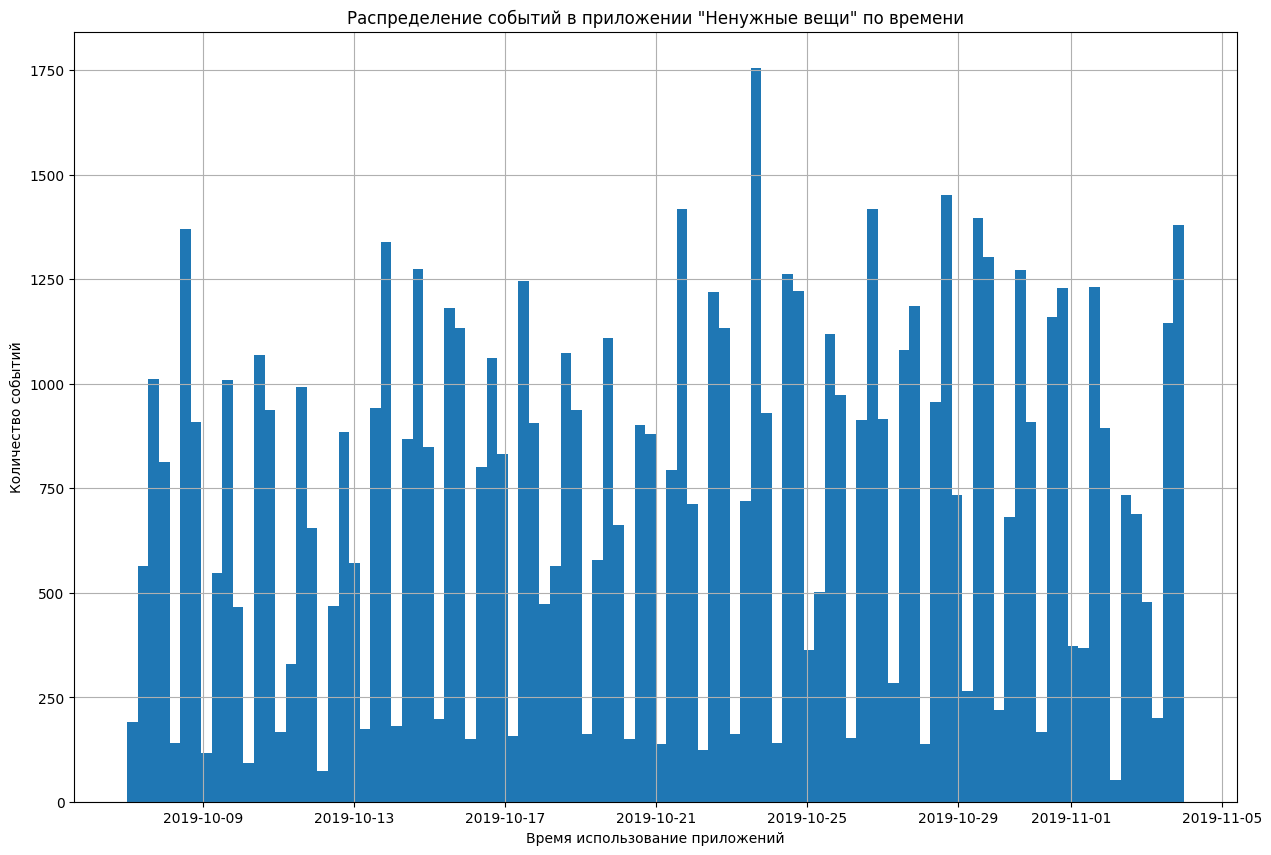

In [18]:
#Построим гистограмму для выявлеия равномерности распределения данных во времени
plt.figure(figsize=(15,10))
mobile_dataset['event_time'].hist(bins=100)
plt.xlabel('Время использование приложений')
plt.ylabel('Количество событий')
plt.title('Распределение событий в приложении "Ненужные вещи" по времени')
plt.show()

Заметно неравномерное распределение событий по дням недели. Выявим дни с наибольшим числом событий с дифференциацией по типам.


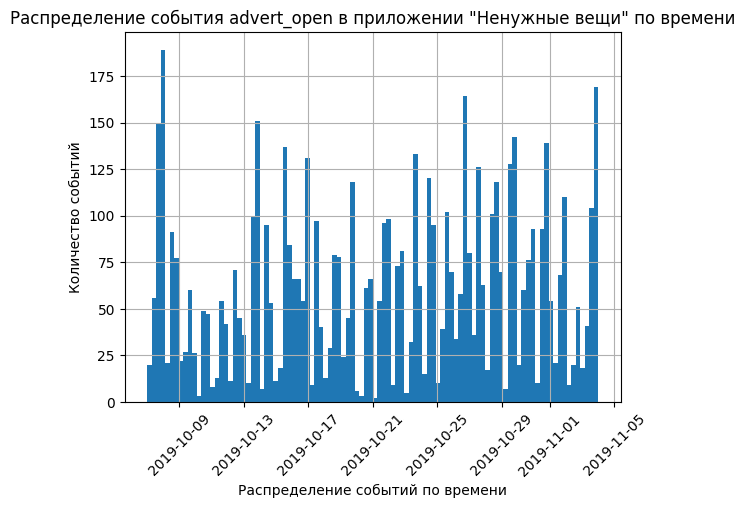

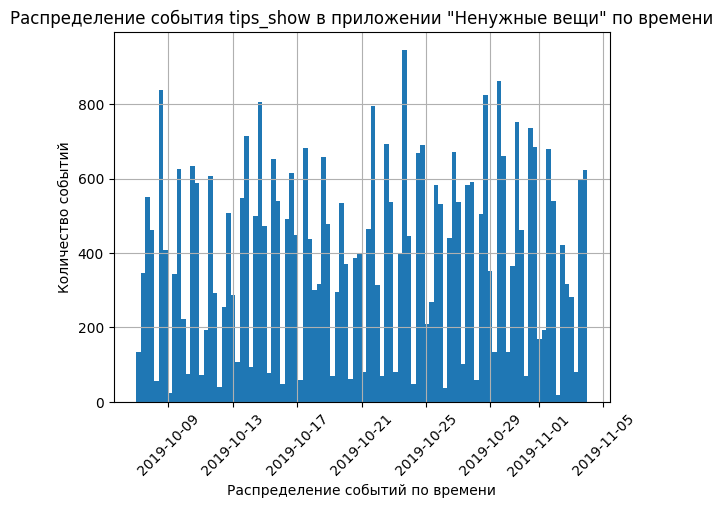

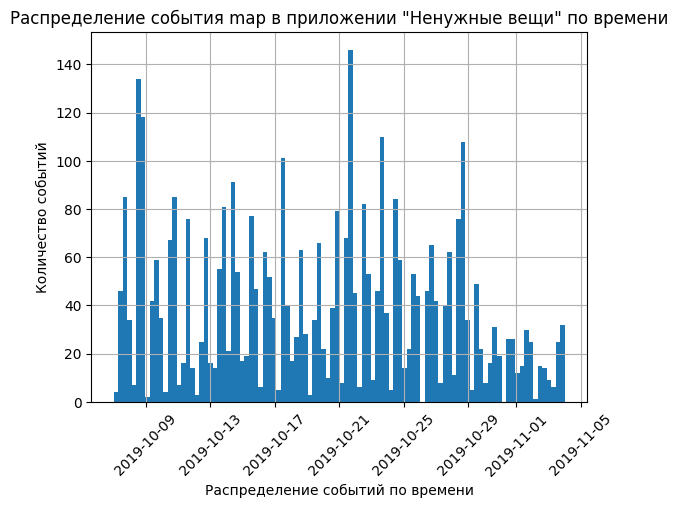

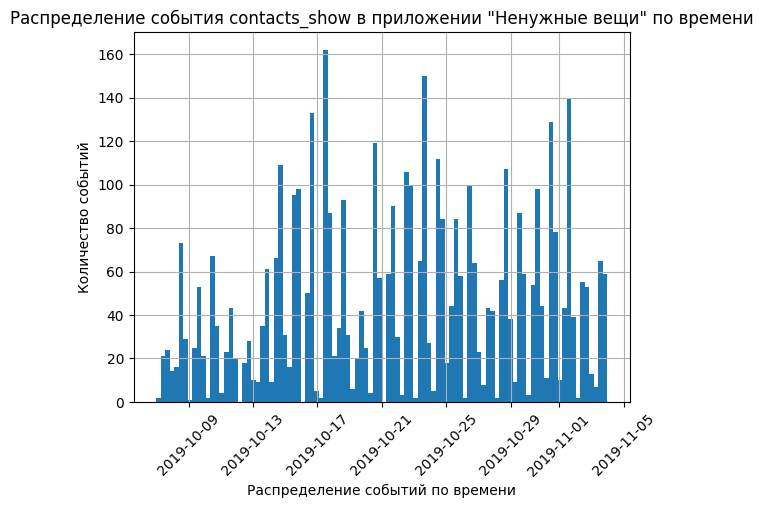

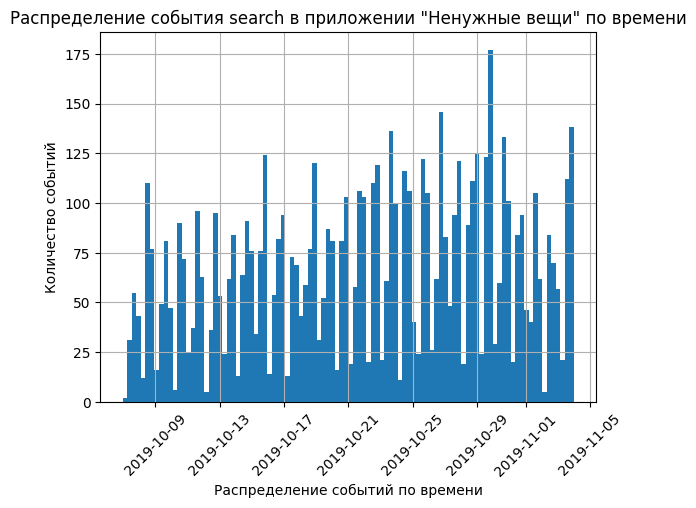

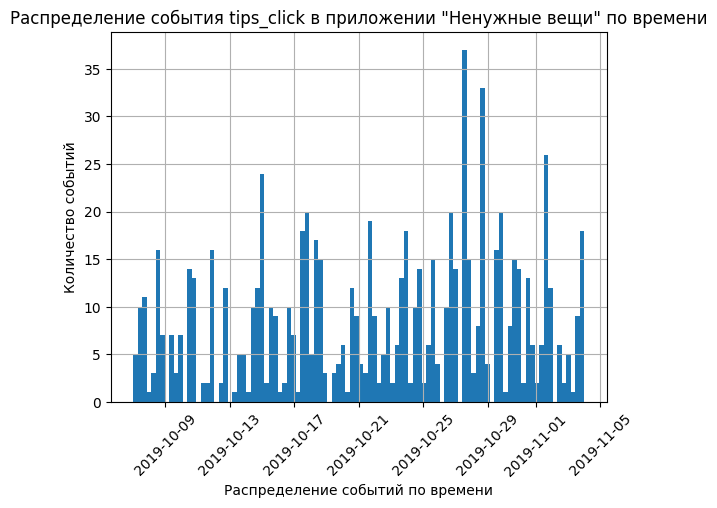

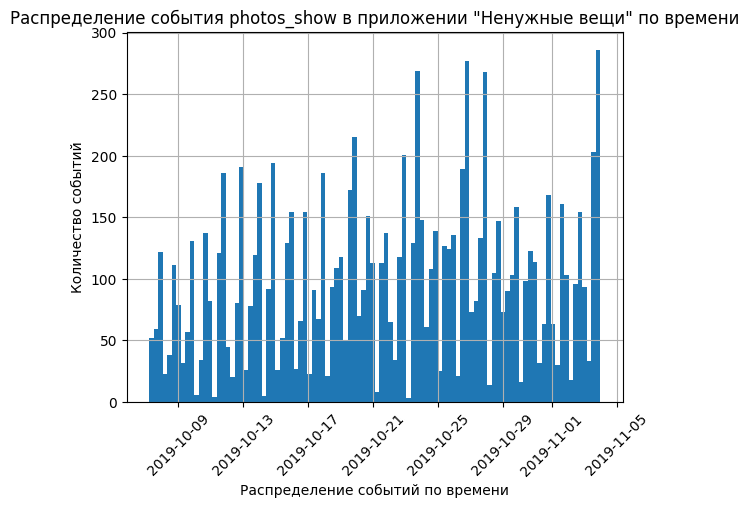

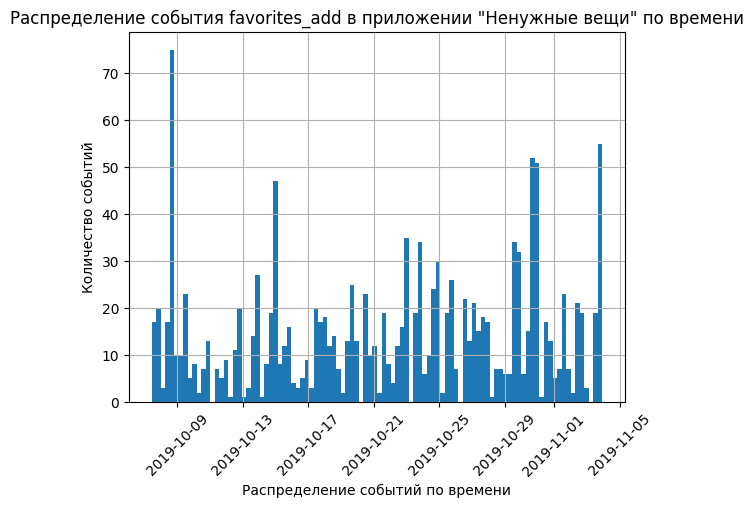

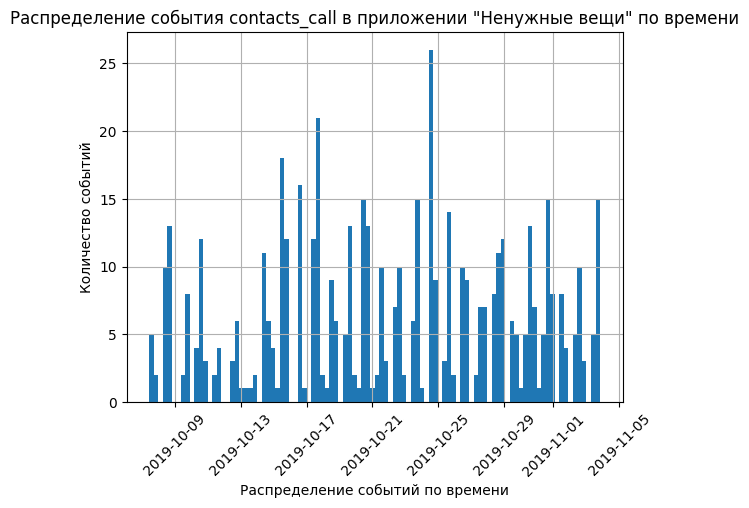

In [19]:
for i in mobile_dataset['event_name'].unique().tolist():
    #a = mobile_dataset.query('event_name == i')
    a = mobile_dataset[mobile_dataset['event_name'] == i]
    a['event_time'].hist(bins=100)
    plt.title(f'Распределение события {i} в приложении "Ненужные вещи" по времени')
    plt.xlabel('Распределение событий по времени')
    plt.ylabel('Количество событий')
    plt.xticks(rotation = 45) 
    plt.show()

In [20]:
mobile_dataset['day'] = mobile_dataset['event_time'].dt.dayofweek

In [21]:
day_pivot = pd.pivot_table(mobile_dataset, index='day', columns = 'event_name', aggfunc='count',values='user_id')
day_pivot

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show
day,,,,,,,,,
0,1121,73,646,142,836,1202,948,147,6556
1,952,86,708,303,642,1316,1106,113,5919
2,845,74,715,239,545,1329,987,111,6150
3,783,118,825,191,547,1291,909,120,5978
4,738,53,665,142,426,1371,939,122,5513
5,694,67,447,161,414,1664,931,83,4693
6,1031,70,523,239,471,1839,964,118,5246


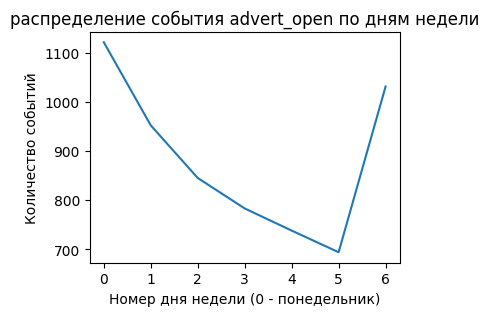

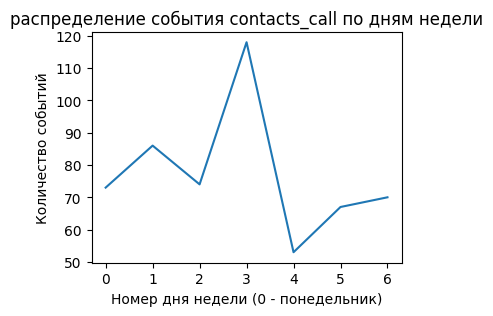

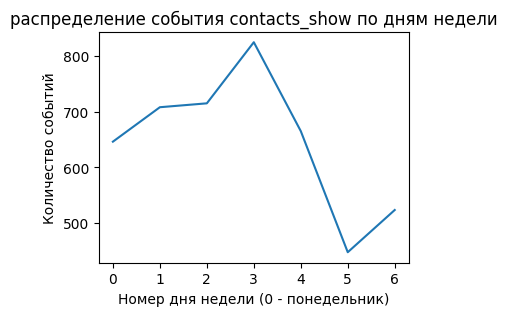

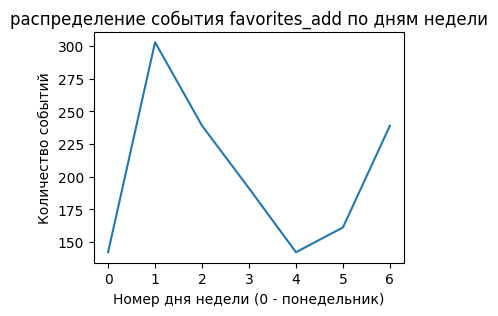

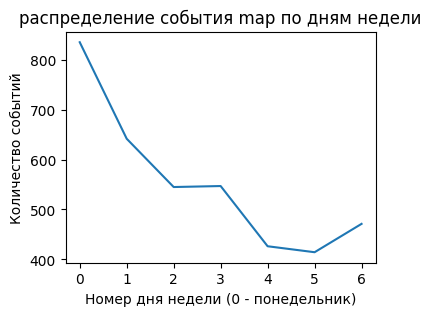

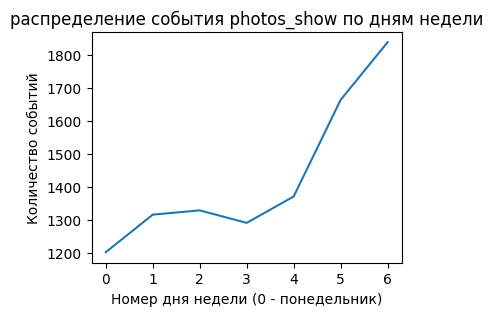

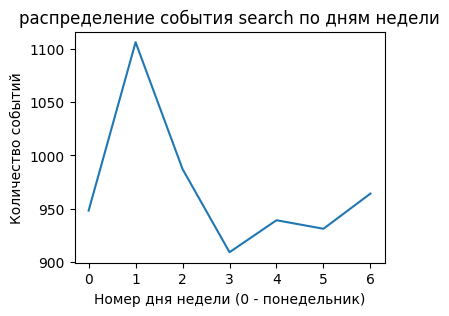

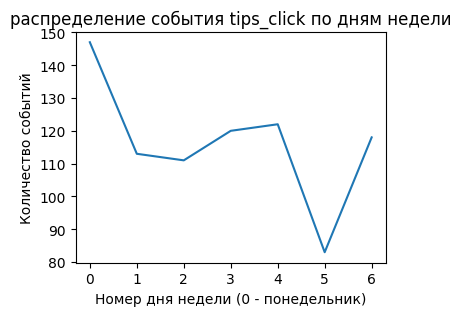

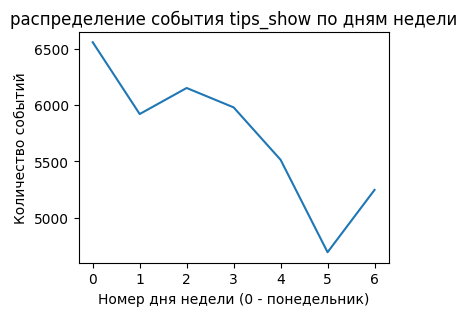

In [82]:
for i in day_pivot.columns:
    a = day_pivot[i] 
    plt.figure(figsize=(4,3))
    a.plot()
    plt.title(f'распределение события {i} по дням недели')
    plt.xlabel('Номер дня недели (0 - понедельник)')
    plt.ylabel('Количество событий')
    plt.show()
    

Конкретного дня недели, для которого был характерен пик по всем событиям нет. Однако если говорить о целевом событии contacts_show, то оно характерно для понедельника-четверга, а ближе к выходным заметен большой спад. То же можно сказать и о звонках по объявлениям. При этом пик просмотров фото в объявлениях приходится на выходные, тогда же люди активно добавляют в избранное и пользуются поиском.

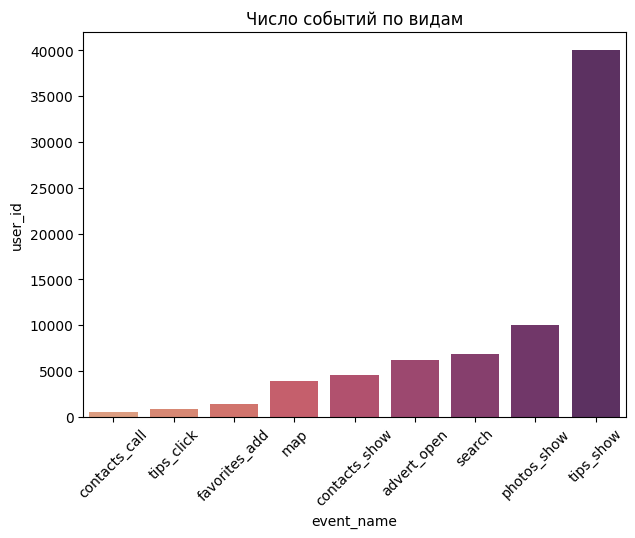

In [86]:
m = mobile_dataset.groupby('event_name').count()['user_id'].reset_index().sort_values('user_id').reset_index(drop=True)
plt.figure(figsize=(7,5))
plt.title('Число событий по видам')
sns.barplot(x = 'event_name', y = 'user_id', data=m, palette="flare")
plt.xticks(rotation = 45)
plt.show()

In [24]:
m = m.set_index('event_name')
photo_ratio = m.loc['photos_show','user_id'] / m.loc['advert_open','user_id']
contacts_ratio = m.loc['contacts_show','user_id'] / m.loc['advert_open','user_id']
call_ratio = m.loc['contacts_call','user_id'] / m.loc['advert_open','user_id']
print(f'В среднем на одно открытие объявления приходится показ {photo_ratio:.{3}} фотографий, {contacts_ratio:.{3}} показа контактов и {call_ratio:.{3}} звонков.')

В среднем на одно открытие объявления приходится показ 1.62 фотографий, 0.735 показа контактов и 0.0878 звонков.


Целевое событие contacts_show является пятым по частотности событием на анализируемом отрезке времени. Самое "популярное" tips_show, однако число tips_click  сравнительно мало. Поэтому построение воронки по всем видам событий в данном случае лишено смысла. При этом можно констатировать, что **в среднем на одно открытие объявления приходится показ 1.6 фотографий, 0.73 показа контактов и 0.088 звонков**.

In [25]:
#Пронумеруем пользовательские сессии (у каждого пользователя своя нумерация)

mobile_dataset = mobile_dataset.sort_values(['user_id', 'event_time'])


time_diff = mobile_dataset.groupby('user_id')['event_time'].diff() 


new_session = (time_diff.isnull()) | (time_diff > '25Min')


mobile_dataset['session_id'] = mobile_dataset.loc[new_session, ['user_id', 'event_time']] \
    .groupby('user_id').rank(method='first').astype(int)

mobile_dataset['session_id'] = mobile_dataset['session_id'].fillna(method='ffill').astype(int)

#временной интервал между событитями в разбивке по пользователям и событиям

mobile_dataset['time_diff'] = mobile_dataset.groupby(['user_id','event_name'])['event_time'].transform('diff')

mobile_dataset.head(50)

,event_time,event_name,user_id,day,session_id,time_diff
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,1,NaT
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,1,0 days 00:00:45.063550
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,1,0 days 00:00:34.669580
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,1,0 days 00:02:15.012972
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,1,0 days 00:02:10.182041
831,2019-10-07 13:45:43.212340,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,1,0 days 00:00:12.294838
832,2019-10-07 13:46:31.033718,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,1,0 days 00:00:47.821378
836,2019-10-07 13:47:32.860234,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,1,0 days 00:01:01.826516
839,2019-10-07 13:49:41.716617,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,1,0 days 00:02:08.856383
6541,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,2,NaT


Традиционно конец сессии принято фиксировать после 30 минут отсутствия событий. Однако, с учетом того, что на сайтах объявлений о продаже б/у-вещей почти не размещаются текстовые описания, фото и видеоматериалы, требующие для изучения (без дополнительных действий) 30 и более минут, для более корректного учета продолжительности сессий **было принято решение сократить период отсечения сессии в случае неактивности пользователя до 25 минут**. 

In [26]:
#добавим поля со временем начала, конца сессии, продолжительности сессии и общего числа событий

mobile_dataset['session_st'] = mobile_dataset.groupby(['user_id','session_id'],as_index=False)['event_time'] \
                               .transform('min')
mobile_dataset['session_end'] = mobile_dataset.groupby(['user_id','session_id'],as_index=False)['event_time'] \
                               .transform('max')
mobile_dataset['session_dur'] = mobile_dataset['session_end'] - mobile_dataset['session_st']

mobile_dataset['first_ts'] = mobile_dataset.groupby(['user_id'],as_index=False)['event_time'] \
                               .transform('min')
mobile_dataset['dt'] = mobile_dataset['first_ts'].dt.date 

mobile_dataset['n_of_events'] = mobile_dataset.groupby(['user_id'],as_index=False)['event_time'] \
                               .transform('count')
mobile_dataset['n_of_sessions'] = mobile_dataset.groupby(['user_id'],as_index=False)['session_id'] \
                               .transform('max')

In [27]:
# присоединим к основному датасету данные об источниках пользователей для облегчения анализа и переведем классы в числовые значения
mdf = mobile_dataset.merge(mobile_sources, on='user_id',how='left')
mdf = pd.get_dummies(mdf, columns=['source'])

In [28]:
# рассчитаем и добавим поле с общей длительнотью сессий пользователей и переведем его в числовой формат. Длительно сессий также переведем в секунды
mdf_total_time = mdf.groupby(['user_id','session_id'])['session_dur'].min().reset_index()
mdf_total_time = mdf_total_time.groupby('user_id')['session_dur'].sum().reset_index()
mdf_total_time.columns = ['user_id','total_time']

mdf = mdf.merge(mdf_total_time,left_on='user_id', right_on='user_id',how = 'left')

mdf['total_time'] = mdf['total_time'].dt.total_seconds()
mdf['session_dur'] = mdf['session_dur'].dt.total_seconds()
mdf['time_diff'] = mdf['time_diff'].dt.total_seconds()


mdf.head(5)

,event_time,event_name,user_id,day,session_id,time_diff,session_st,session_end,session_dur,first_ts,dt,n_of_events,n_of_sessions,source_google,source_other,source_yandex,total_time
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,1,NaN,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,595.727258,2019-10-07 13:39:45.989359,2019-10-07,35,4,0,1,0,2760.557106
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,1,45.063550,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,595.727258,2019-10-07 13:39:45.989359,2019-10-07,35,4,0,1,0,2760.557106
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,1,34.669580,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,595.727258,2019-10-07 13:39:45.989359,2019-10-07,35,4,0,1,0,2760.557106
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,1,135.012972,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,595.727258,2019-10-07 13:39:45.989359,2019-10-07,35,4,0,1,0,2760.557106
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,1,130.182041,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,595.727258,2019-10-07 13:39:45.989359,2019-10-07,35,4,0,1,0,2760.557106


In [29]:
#добавим в датафрейм данные о числе событий по каждому пользователю
mdf['event_name'].unique().tolist()

['tips_show',
 'map',
 'search',
 'photos_show',
 'favorites_add',
 'contacts_show',
 'contacts_call',
 'advert_open',
 'tips_click']

In [30]:
events=mdf[mdf['event_name'] == 'tips_show'].groupby('user_id').count()['event_name'].reset_index()

for i in ['map',
 'search',
 'photos_show',
 'favorites_add',
 'contacts_show',
 'contacts_call',
 'advert_open',
 'tips_click']:
     
        b = mdf[mdf['event_name'] == i].groupby('user_id').count()['event_name'].reset_index()
        events = events.merge(b, left_on='user_id', right_on='user_id',how = 'outer')
events.columns = ['user_id','tips_show','map','search','photos_show','favorites_add','contacts_show','contacts_call','advert_open','tips_click']
events.fillna(0)

,user_id,tips_show,map,search,photos_show,favorites_add,contacts_show,contacts_call,advert_open,tips_click
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,29.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,4.0,6.0,17.0,0.0,0.0,0.0,0.0,5.0,0.0
2,00554293-7e00-4122-b898-4e892c4a7c53,9.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,005fbea5-2678-406f-88a6-fbe9787e2268,2.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
4,007d031d-5018-4e02-b7ee-72a30609173f,5.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4288,f15c6c88-5083-4331-b213-c8dc9076d517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0
4289,f9593e8d-804a-44ff-9c1a-e3762118bc3e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
4290,8d4cad12-c23d-4ef5-8d23-846bbd47bb50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4291,e6160ded-5b2d-4890-aa6f-9d5956e9a156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


In [31]:
mdf = mdf.merge(events,left_on='user_id', right_on='user_id',how = 'left')


In [32]:
mdf = mdf.fillna(0)

In [33]:
#Построим таблицу признаков 

mdf_groupped_raw = mdf.groupby('user_id').mean().fillna(0)

In [34]:
#Очистим датафрейм от случайных пользователей с одним событием

mdf_groupped = mdf_groupped_raw[mdf_groupped_raw['n_of_events'] != 1]

In [35]:
print ('Доля потерянных пользователей после исключения: ', (len(mdf_groupped_raw) - len(mdf_groupped)) / len(mdf_groupped_raw))

Доля потерянных пользователей после исключения:  0.015140927090612625


Доля потерянных после очистки датасета пользователей составляет менее 2% и является приемлемой.

In [36]:
mdf_groupped_raw.describe()

,day,session_id,time_diff,session_dur,n_of_events,n_of_sessions,source_google,source_other,source_yandex,total_time,tips_show,map,search,photos_show,favorites_add,contacts_show,contacts_call,advert_open,tips_click
count,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000
mean,2.924532,1.696530,19976.757499,960.843655,17.283252,2.476823,0.262986,0.286513,0.450501,1764.921669,9.330305,0.904030,1.580247,2.332169,0.330072,1.054973,0.126019,1.435826,0.189611
std,1.836056,1.706182,49565.326682,1070.887674,29.130677,3.690652,0.440306,0.452185,0.497602,3466.536017,19.877676,3.040441,3.778452,8.386409,2.109938,4.989622,0.765462,6.156880,1.044630
min,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.375000,1.000000,72.561405,274.993538,5.000000,1.000000,0.000000,0.000000,0.000000,359.591545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,229.350553,638.185558,9.000000,1.000000,0.000000,0.000000,0.000000,865.154290,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.235294,1.800000,14745.042914,1295.299301,17.000000,3.000000,1.000000,1.000000,1.000000,1897.246202,10.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,42.297500,741137.364780,18902.924065,478.000000,105.000000,1.000000,1.000000,1.000000,92636.641035,346.000000,71.000000,68.000000,177.000000,63.000000,137.000000,17.000000,137.000000,30.000000


У медианного пользователя приложения в анализируемом периоде была **всего одна сессия, при этом он ни разу не открывал поиск, не добавлял в избранное, не открывал страницу объявления и не просматривал контакты. В основном его действия набирались за счет предложения объявлений, то есть не зависящих от пользователя событий**. На 45% поток пользователей формировался за счет Яндекса, на 29% за счет прочих источников и 26% приходили по каналам Google. 

## Кластеризация пользователей <a class ="anchor" id="chapter3"></a>

In [37]:
#стандартизируем данные таблицы признаков и строим матрицу расстояний
scaler = StandardScaler()
scaler.fit(mdf_groupped)
mdf_st = scaler.transform(mdf_groupped)

linked = linkage(mdf_st, method = 'ward') 

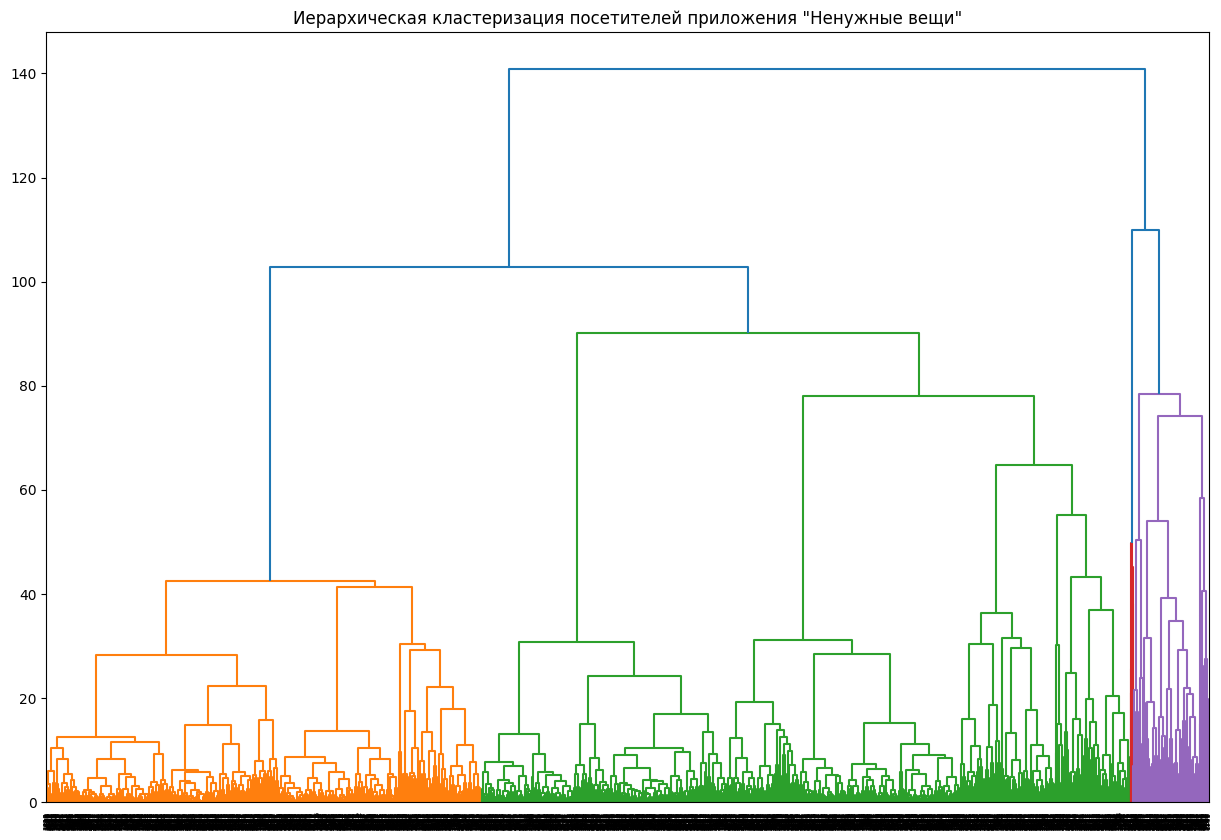

In [38]:
#строим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация посетителей приложения "Ненужные вещи"')
plt.show() 

Дендраграмма предлагает разделить клиентов на **три кластера**, проведем разделение пользователей на три группы.

In [39]:
#разбиваем выборку на кластеры и разметим сгруппированный по user_id датафрейм
km = KMeans(n_clusters=3, random_state=0) 
labels = km.fit_predict(mdf_st)
mdf_groupped['cluster_number'] = labels

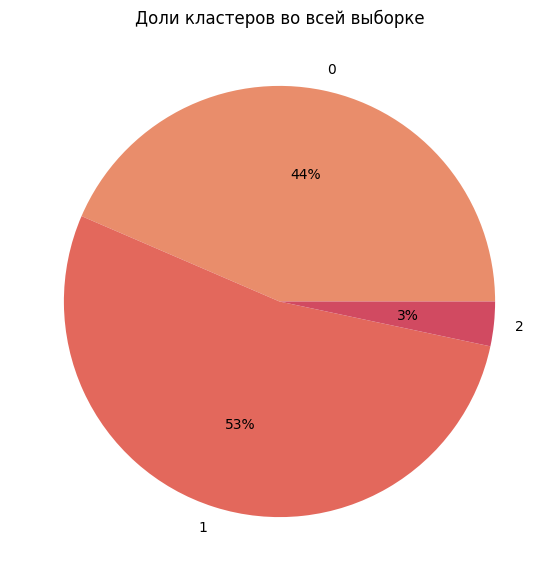

In [40]:
#построим пайчарт с долями кластеров во всей выборке
colors = sns.color_palette('flare')
labels = mdf_groupped.groupby('cluster_number').count().index
plt.figure(figsize=(7, 7)) 
plt.pie(mdf_groupped.groupby('cluster_number').count()['contacts_show'],radius=1,colors=colors,labels=labels,autopct='%.0f%%')
plt.title('Доли кластеров во всей выборке')
plt.show()

In [41]:
mdf_groupped.groupby('cluster_number').mean()

,day,session_id,time_diff,session_dur,n_of_events,n_of_sessions,source_google,source_other,source_yandex,total_time,tips_show,map,search,photos_show,favorites_add,contacts_show,contacts_call,advert_open,tips_click
cluster_number,,,,,,,,,,,,,,,,,,,
0,2.963535,1.477524,19140.349584,970.591983,13.809783,2.016848,0.000000,0.000000,1.000000,1459.507653,8.036413,0.774457,1.165761,1.671196,0.253261,0.806522,0.111413,0.830978,0.159783
1,2.895948,1.525573,20964.724606,884.703845,13.471740,2.097908,0.480641,0.519359,0.000000,1308.392872,6.712061,0.666222,1.551847,2.208723,0.238540,0.678683,0.121940,1.164664,0.129061
2,2.907217,7.599957,24356.315727,2489.950503,130.858156,15.198582,0.262411,0.276596,0.460993,13839.403288,72.028369,6.687943,8.113475,13.971631,2.943262,10.737589,0.439716,14.304965,1.631206


In [42]:
mdf_groupped.query('cluster_number == 2').mean()

day                   2.907217
session_id            7.599957
time_diff         24356.315727
session_dur        2489.950503
n_of_events         130.858156
n_of_sessions        15.198582
source_google         0.262411
source_other          0.276596
source_yandex         0.460993
total_time        13839.403288
tips_show            72.028369
map                   6.687943
search                8.113475
photos_show          13.971631
favorites_add         2.943262
contacts_show        10.737589
contacts_call         0.439716
advert_open          14.304965
tips_click            1.631206
cluster_number        2.000000
dtype: float64

**Поведение пользователей нулевого и первого кластеров в целом подобно и отличается в первую очередь источниками перехода. В нулевом кластере сосредодочились юзеры из "Яндекса", а в нулевом примерно поровну юзеров Google и привлеченнызх из иных площадок**. Оба кластера характеризуются низкой пользовательсокй активностью. Большинство попавших в них пользователей провели в приложении за анализируемый месяц меньше получаса и в течение 1-2 сессий сделали менее 20 событий (включая tips_show, которые от действий пользователей прямо не зависят). Действия ва приложении в данных кластерах примерно равномерно распределены по дням недели.

**Наиболее активные пользователи собраны во втором, самом маленьком по числу пользователей кластере, кластере. На него приходится 3% пользователей** Они наиболее активны в середине недели. За анализируемый периоду у них было было больше 17 сессий общей длительностью почти 2,4 тыс. секунд. В среднем за месяц они провели в приложении почти 15 тыс. секунд - или более 4 часов, совершив 142 действия и открыв 16 объявлений.

**Доля "Яндекса" как источника (44%) в данной групп значительно превосходит долю Google (30%) и остальные источники (27%).**

**Однако кластер с наиболее активными пользователями слишком мал (3%). Попробуем убрать самое распостроненное событие tips_show, не являющееся действием пользователя и несколько "зашумляющее" данные, сделаем новую дендрограмму и кластеризацию**.

В связи с некорречтным делением на кластеры проверим данные на мультиколлиниарность.

In [43]:
cm = sns.light_palette("blue", as_cmap=True)
mdf_groupped.corr().style.background_gradient(cmap=cm)

,day,session_id,time_diff,session_dur,n_of_events,n_of_sessions,source_google,source_other,source_yandex,total_time,tips_show,map,search,photos_show,favorites_add,contacts_show,contacts_call,advert_open,tips_click,cluster_number
day,1.000000,0.000514,-0.003776,0.002383,-0.013236,-0.004821,0.016732,-0.034329,0.016327,-0.003508,-0.024431,-0.053101,0.004757,0.047214,0.003094,-0.017725,-0.012465,-0.008922,-0.005496,-0.016806
session_id,0.000514,1.000000,0.191826,0.070714,0.693878,0.973779,0.013094,0.013502,-0.023856,0.679793,0.534069,0.335735,0.387868,0.348658,0.150135,0.430664,0.122933,0.225491,0.202694,0.311645
time_diff,-0.003776,0.191826,1.000000,-0.144273,-0.003867,0.180945,-0.022230,0.041408,-0.017878,-0.008817,-0.042228,-0.000639,0.113336,0.037068,0.017913,0.005978,0.027737,-0.014650,-0.009024,0.022920
session_dur,0.002383,0.070714,-0.144273,1.000000,0.445999,0.073653,0.005547,-0.053738,0.043852,0.551014,0.474899,0.201678,0.015357,0.041835,0.140833,0.172944,-0.004573,0.192284,0.167096,0.088674
n_of_events,-0.013236,0.693878,-0.003867,0.445999,1.000000,0.708942,0.015536,-0.030476,0.013890,0.889660,0.870701,0.584263,0.275145,0.268827,0.286425,0.534917,0.054469,0.503921,0.284570,0.332813
n_of_sessions,-0.004821,0.973779,0.180945,0.073653,0.708942,1.000000,0.014593,0.005581,-0.017996,0.693235,0.560768,0.367310,0.371087,0.328639,0.155812,0.428355,0.124446,0.231552,0.206649,0.307854
source_google,0.016732,0.013094,-0.022230,0.005547,0.015536,0.014593,1.000000,-0.378532,-0.542625,0.014996,-0.016183,0.000859,0.049779,0.052151,0.010257,0.026051,0.013965,-0.000624,-0.012772,0.470350
source_other,-0.034329,0.013502,0.041408,-0.053738,-0.030476,0.005581,-0.378532,1.000000,-0.572070,-0.043832,-0.034126,-0.033439,0.002783,0.000329,-0.035781,-0.024926,-0.001573,0.013521,-0.002084,0.494977
source_yandex,0.016327,-0.023856,-0.017878,0.043852,0.013890,-0.017996,-0.542625,-0.572070,1.000000,0.026489,0.045310,0.029585,-0.046638,-0.046512,0.023382,-0.000465,-0.010947,-0.011718,0.013209,-0.865992
total_time,-0.003508,0.679793,-0.008817,0.551014,0.889660,0.693235,0.014996,-0.043832,0.026489,1.000000,0.801118,0.536183,0.222623,0.231331,0.213865,0.572200,0.034290,0.303992,0.328656,0.282929


Многие расчетные поля значительно коррелируют между собой, что не дает возможности корректно провести разделение на кластеры. Попробуем провести кластеризацию только на основании кликстрима в датасете mobile_dataset (без событий tips_show)**. Для этого воспользуемся библиотекой Retentioneering. В качестве целевого действия укажем contacts_show.

In [44]:
data =  mobile_dataset.query('event_name != "tips_show"')[['event_time','event_name','user_id']]

In [45]:
# конфигурируем Retentioneering
retentioneering.config.update({
    'user_col': 'user_id',
    'event_col':'event_name',
    'event_time_col':'event_time',
})

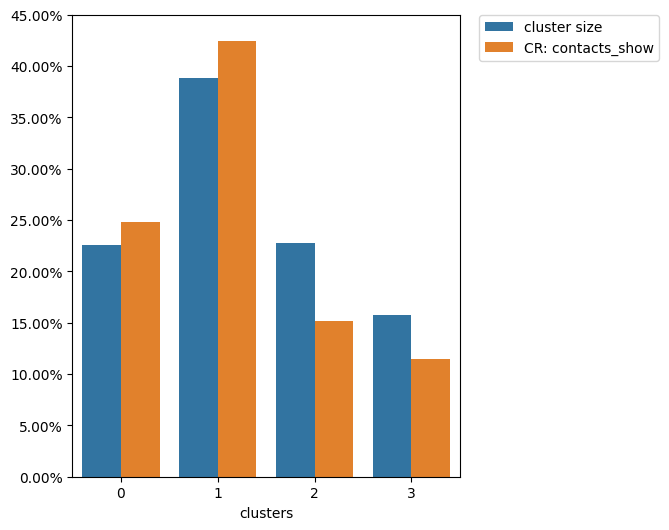

In [46]:
data.rete.get_clusters(method='kmeans',
                       feature_type='tfidf',
                       n_clusters=4,
                       ngram_range=(1,2),
                       plot_type='cluster_bar',
                       targets=['contacts_show']);

Целевое событие не имеет ярко выраженных отличий в зависимости от кластера. **Увеличим количество кластеров до 6 для выделения специфики**.

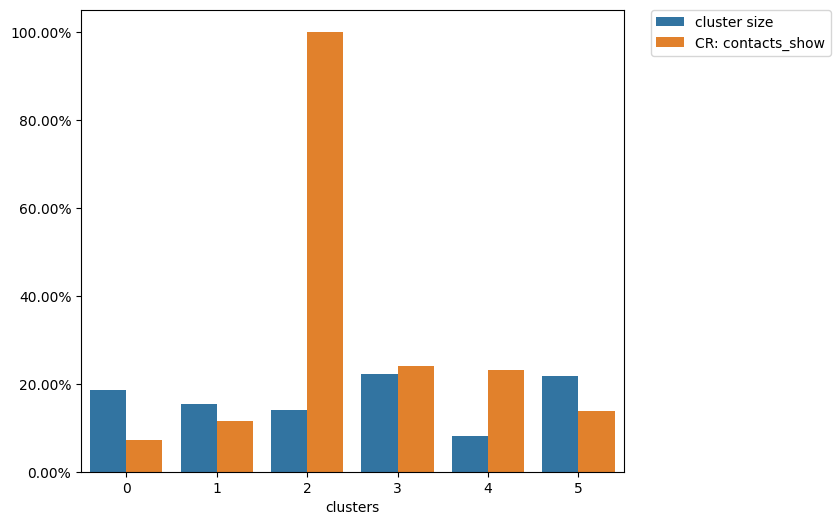

In [47]:
data.rete.get_clusters(method='kmeans',
                       feature_type='tfidf',
                       n_clusters=6,
                       ngram_range=(1,2),
                       plot_type='cluster_bar',
                       targets=['contacts_show']);

Кластеры сопоставимы по размеру. Целевое действие **явно превалирует во втором кластере**.

,0,1
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,-8.030804,20.938711
00157779-810c-4498-9e05-a1e9e3cedf93,18.236036,-2.151082
00463033-5717-4bf1-91b4-09183923b9df,24.158785,-8.559613
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,-20.091187,-1.568720
00551e79-152e-4441-9cf7-565d7eb04090,18.033686,2.168349
...,...,...
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,-9.778643,22.935686
ffc01466-fdb1-4460-ae94-e800f52eb136,20.225422,-5.063806
ffcf50d9-293c-4254-8243-4890b030b238,-8.899357,23.960814
ffe68f10-e48e-470e-be9b-eeb93128ff1a,10.553777,-15.839957


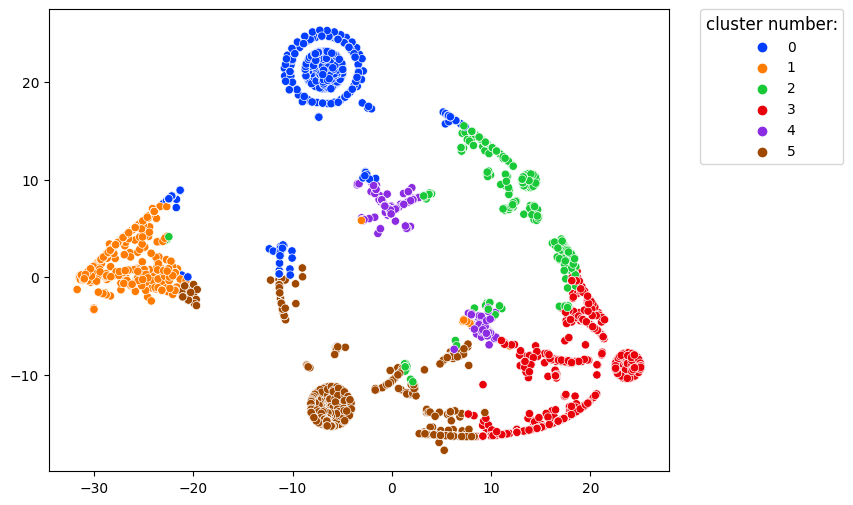

In [48]:
#визуализируем кластеризацию

data.rete.project(plot_type ='clusters',
                  method='tsne',
                  perplexity=128)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid " ><b> ⬆ Комментарии от тимлида ✔️ : </b> 

Здорово, что добавил визуализацию
   
</div>

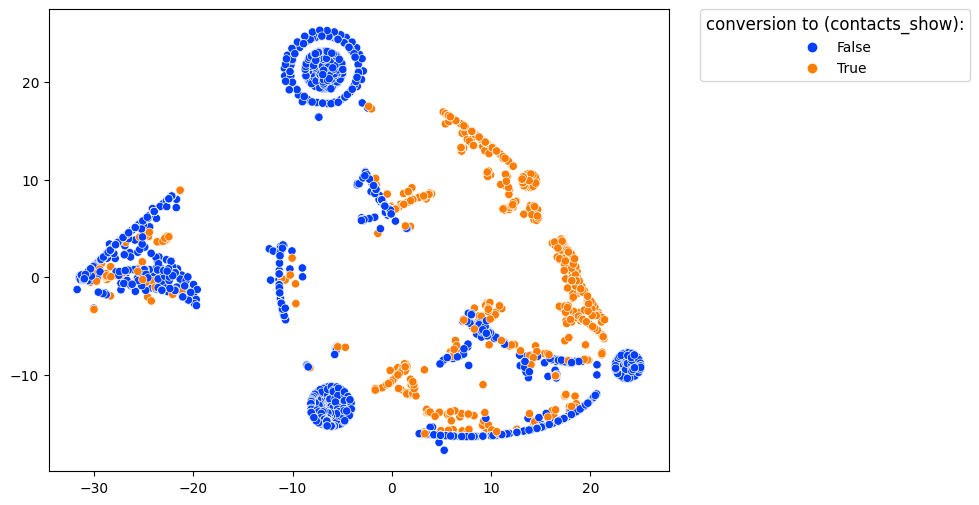

In [49]:
#Выделим на диаграмме целевое событие contacts_show

data.rete.project(plot_type ='targets',
                  targets = ['contacts_show'],
                  method='tsne',
                  perplexity = 128);

Как видно на диаграммых, целевое действие состредоточено в первую очередь в зеленом и красном кластерах, то есть во втором и третьем. 

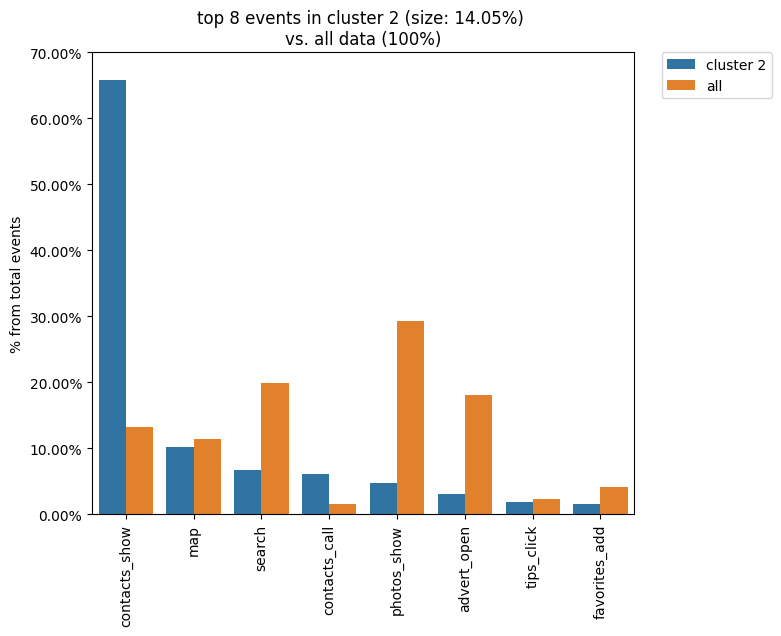

In [50]:
#Сравним второй кластер в разрезе событий со всей выборкой
data.rete.cluster_event_dist(2)

Пользователи второго кластера значительно меньше добавляют объявления в избранное, открывают сообщения и пользуются поиском. При этом совершают значительно больше звонков по показанным контактам. При этом они значительно меньше открывают сами карточки товаров. Можно предположить специфику поведения пользователей в данном кластере. Изучим поведение пользователей более подробно на визуализации переходов между событиями.

In [51]:
data.rete.plot_graph(norm_type='node', weight_col='user_id',thresh=0.15, targets = {'contacts_show':'green'})

'experiments/graph_2022-10-08 17_33_53_407755.html'

**Большинство (половина) целевых событий contacts_show происходят после такого же события**. Также значителен объем "переходов" из contacts_call и photos_show. При этом прямых переходов из открытия объявления в показ контактов в значимых объемах нет. Вероятно, это обусловлено спецификой использования сервиса, когда пользователь открывает сразу много объявлений в разных вкладках и потом "открывает" контакты после звонка в предыдущей вкладке или просмотра фото. Но чаще всего просто переходит в новую вкладку и, не просматривая фото дополнительно, открывает контакты. 


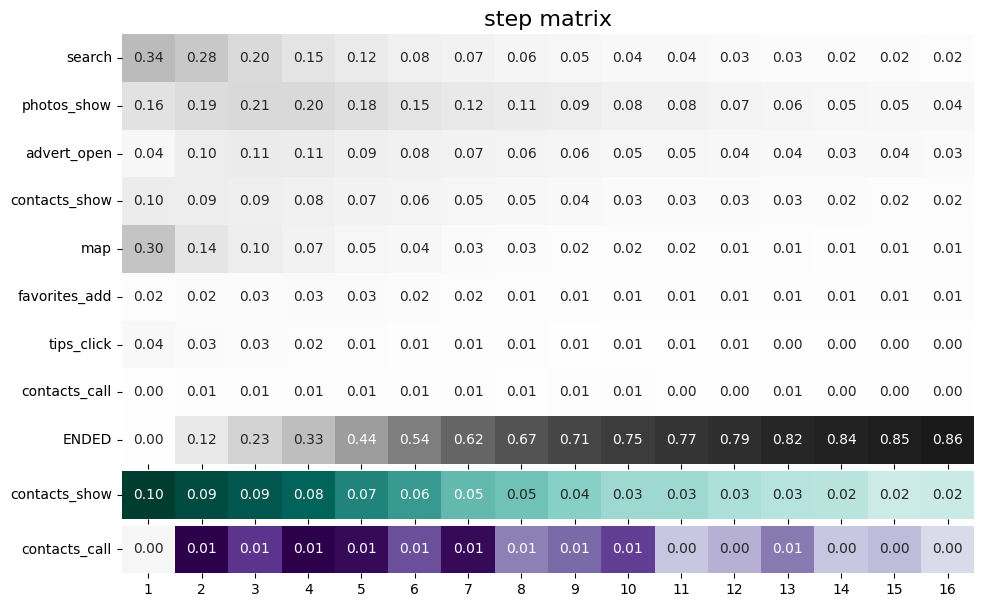

In [52]:
data.rete.step_matrix(max_steps=16,
                      thresh=0.00,
                      targets=['contacts_show','contacts_call']);

**На матрице шагов клиентов видно, что показ контакта имеет максимальную долю среди всех событий на первом шаге. Это, видимо, объясняется тем, что пользователи в значительном объеме попадают на экран открытия контактов по прямой внешней ссылке, минуя экраны поиска, карты объявлений и самой карточки объявления**. Впрочем для большинства пользователей сервиса первым шагом является поиск, карта объявлений и просмотр фото (на страницу также, вероятно, попадают по прямой ссылке). С каждым последующим шагом пользователей доля открытия контактов плавно снижается. Она наиболее велика во время первых шести шагов.

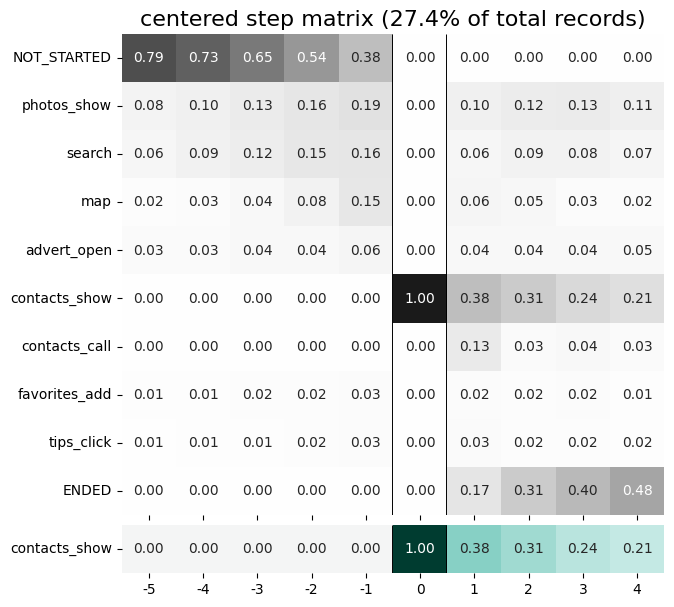

In [53]:
data.rete.step_matrix(max_steps=10,
                      thresh = 0.0,
                      centered={'event':'contacts_show',
                                'left_gap':5,
                                'occurrence':1},
                      targets=['contacts_show']);

**На центрированной матрице шагов мы видим, что в "просмотр контактов" основная масса пользователей попадает не из приложения - у 38% из тех, у кого было открытие контактов, не было предыдущего события внутри приложения**. 19% в предыдущем действии просматривали фото, 16% - поиск и 15% - карту объявлений. Чаще всего просмотрев контакты пользователь уходит в новый просмотр контактов (38%), или уходит из приложения не позвонив (17%) или звонит (13%). Впрочем, вероятно низкая конверсия в звонок связана с тем, что приложение не может отследить звонок по внешнему устройству и реально конверсия выше. Поэтому конверсию в звонок следует анализировать с осторожностью.

Проведем разметку кластеров в основном датасете.

In [54]:
clus_0 = data.rete.cluster_mapping[0]
clus_1 = data.rete.cluster_mapping[1]   
clus_2 = data.rete.cluster_mapping[2]
clus_3 = data.rete.cluster_mapping[3]
clus_4 = data.rete.cluster_mapping[4]
clus_5 = data.rete.cluster_mapping[5]

In [55]:
def c_number(line): 
    if line['user_id'] in clus_0:
        return 0
    if line['user_id'] in clus_1:
        return 1
    if line['user_id'] in clus_2:
        return 2
    if line['user_id'] in clus_3:
        return 3
    if line['user_id'] in clus_4:
        return 4
    return 5

In [56]:
mdf_groupped = mdf_groupped.reset_index().drop(columns=['cluster_number'])
mdf_groupped['c_number'] = mdf_groupped.apply(c_number,axis=1)

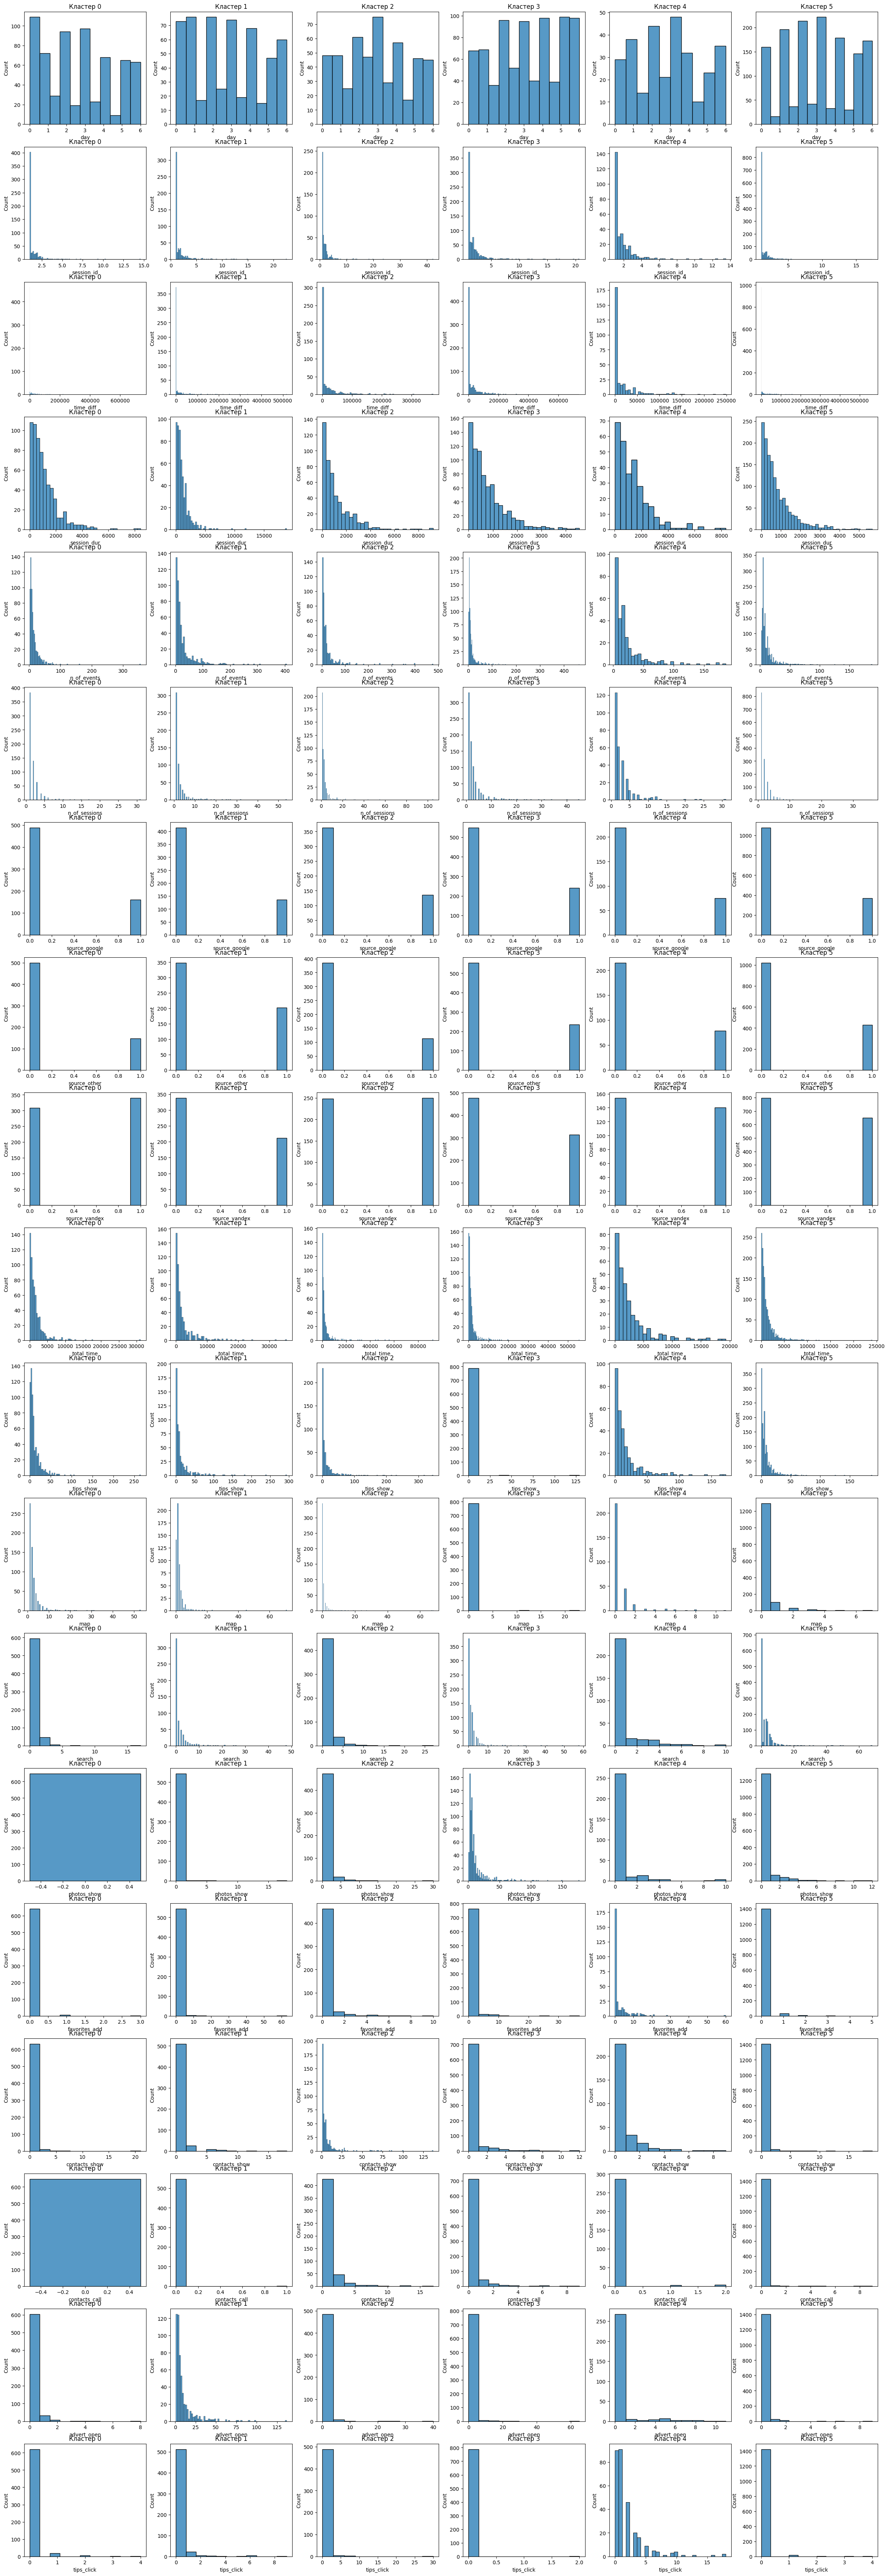

In [57]:
#Строим распределения признаков для кластеров
plt.figure(figsize=(30,90))
for i, col in enumerate(mdf_groupped.drop(['user_id', 'c_number'], axis=1).columns):
    for cluster in np.sort(mdf_groupped['c_number'].unique()):
        sns.histplot(data=mdf_groupped[mdf_groupped['c_number']==cluster], x=col, ax=plt.subplot(19, 6, (cluster+1)+i*6))
        plt.title(r"Кластер " + str(cluster))

In [58]:
cm = sns.light_palette("blue", as_cmap=True)
mdf_groupped.groupby('c_number').mean().style.background_gradient(cmap=cm)

,day,session_id,time_diff,session_dur,n_of_events,n_of_sessions,source_google,source_other,source_yandex,total_time,tips_show,map,search,photos_show,favorites_add,contacts_show,contacts_call,advert_open,tips_click
c_number,,,,,,,,,,,,,,,,,,,
0,2.682559,1.444248,16883.801000,1113.126838,15.683642,1.973765,0.246914,0.228395,0.524691,1693.264053,12.237654,2.845679,0.276235,0.000000,0.012346,0.148148,0.000000,0.104938,0.058642
1,2.795333,1.770428,15273.557688,1120.699236,29.116364,2.650909,0.247273,0.367273,0.385455,2252.315748,14.930909,1.910909,1.525455,0.078182,0.285455,0.347273,0.003636,9.883636,0.150909
2,2.923032,2.097699,18844.558359,1170.288064,25.279116,3.379518,0.271084,0.226908,0.502008,2929.961260,14.801205,1.068273,0.696787,0.489960,0.168675,6.891566,0.644578,0.327309,0.190763
3,3.182726,1.995444,29058.980207,781.815213,15.331646,3.040506,0.305063,0.298734,0.396203,1616.068083,0.267089,0.044304,1.767089,11.678481,0.458228,0.559494,0.201266,0.353165,0.002532
4,2.889753,1.868313,17782.868473,1396.685524,23.146259,2.901361,0.255102,0.268707,0.476190,2596.851741,16.319728,0.534014,0.537415,0.316327,2.506803,0.496599,0.037415,0.489796,1.908163
5,2.952124,1.476695,19923.834536,812.256920,11.359807,1.997928,0.255525,0.295580,0.448895,1202.701004,7.944061,0.169890,2.663674,0.277624,0.047652,0.149171,0.033149,0.050414,0.024171


Самое высокое среднее число показов на пользователя наблюдается в первом кластере, при том что лидером по числу целевых действий - contacts_show, - является второй. В нем число открытий объявлений на человека меньше всего - 0,33, сравнительно немного событий, связанных с внутренним поиском (0,7 при максимуме в пятой группе 2,7). Что является еще одним косвенным подверждением прямого перехода из внешних источников сразу в целевое действие. При этом в "целевом", втором кластере сосредоточены сравнительно активные клиенты, они отсличаются высоким средним временем проведенным на сайте по итогам анализируемого периода - 2930 секунд и просмотром фото (второй результат по кластерам - 0,5 на пользователя). При этом у них средние показатели по добавлению в избранное. Вместо этого пользователи из второго кластера, вероятно, открывают несколько вкладок и потом многократно создают событие contacts_show.

Второй кластер лидирует по числу сессий, что может свидетельствовать о том, что пользователи совершающие целевое действие, относятся к категории самых активных пользователей. 

**В "целевом" кластере велика доля посетителей, пришедших из "Яндекса" (50%), что дает основания полагать, что именно оттдуда впервую очередь приходят пользователи по внешним ссылкам сразу на целевое действие**. 

## Расчет удержания пользователей <a class ="anchor" id="chapter4"></a>

Покупка б/у-вещей не является сервисом высокой частоты использования, поэтому недельный лайфтайм может быть слишком мал для фиксирования положения дел, а трехнедельный слишком велик, потому что у нас данные за один месяц и мы должны будем исключить из анализа три четверти данных, так как они "не дожили" до необходимого лайфтайма. Поэтому рассчитаем retention rate на 14-й день.

In [59]:
#размечаем кластеры в датафрейме с событиями
id_and_clusters = mdf_groupped[['user_id','c_number']]
mdf = mdf.merge(id_and_clusters, on = 'user_id')
mdf = mdf.merge(mobile_sources, on = 'user_id')

In [60]:
horizon_days = 14
observation_date = mdf['session_st'].max().date()
dimensions = ['c_number']

In [61]:
# Создаем функцию расчета удержания

def get_retention(df,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    dimensions = dimensions
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = df.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
   
    result_raw['lifetime'] = (
        result_raw['session_st'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [62]:
# Получаем расчеты удержания
retention_raw, retention_grouped, retention_history = get_retention(
    mdf, observation_date, horizon_days,dimensions=dimensions)

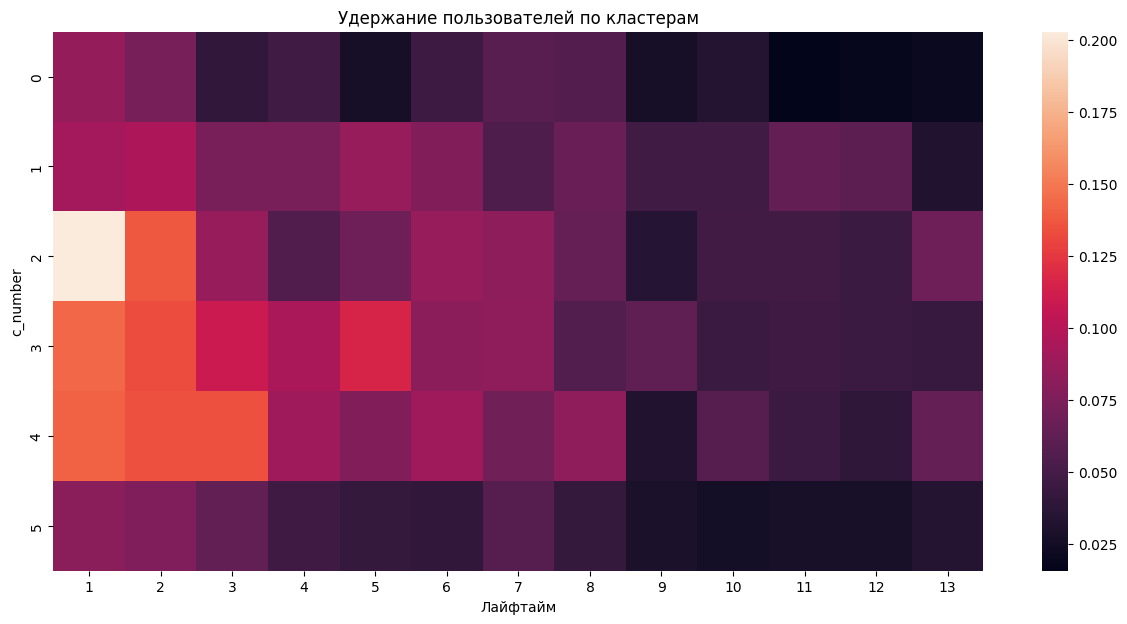

In [63]:
plt.figure(figsize=(15,7))
sns.heatmap(retention_grouped.drop(columns=['cohort_size', 0]))
plt.xlabel('Лайфтайм')
plt.title('Удержание пользователей по кластерам')
plt.show()

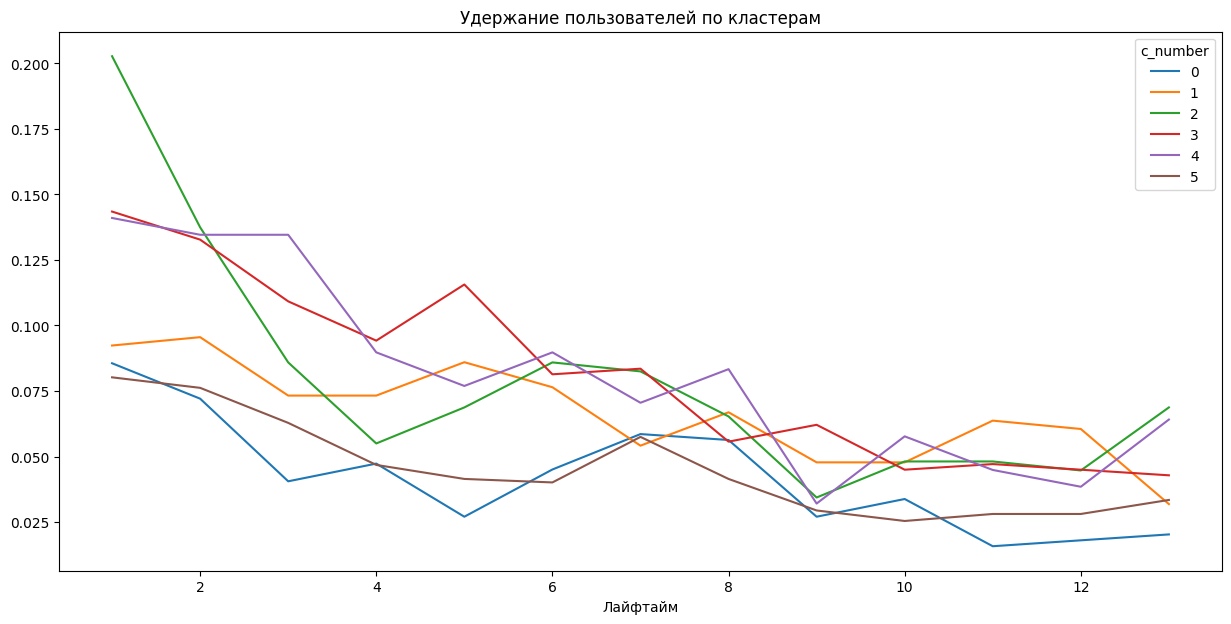

In [64]:
retention_grouped.drop(columns=['cohort_size', 0]).T.plot(figsize=(15,7))
plt.xlabel('Лайфтайм')
plt.title('Удержание пользователей по кластерам')
plt.show()

Во втором "целевом" кластере  наблюдается максимальный уровень удержания клиентов, затем он усредняется с другими кластерами но к 14-му дню вновь выходит на первое место на уровне порядка 7,5%. Таким образом, группа с максимальным средним показателем совершения целевого действия обладает максимальным уровнем удержания. 


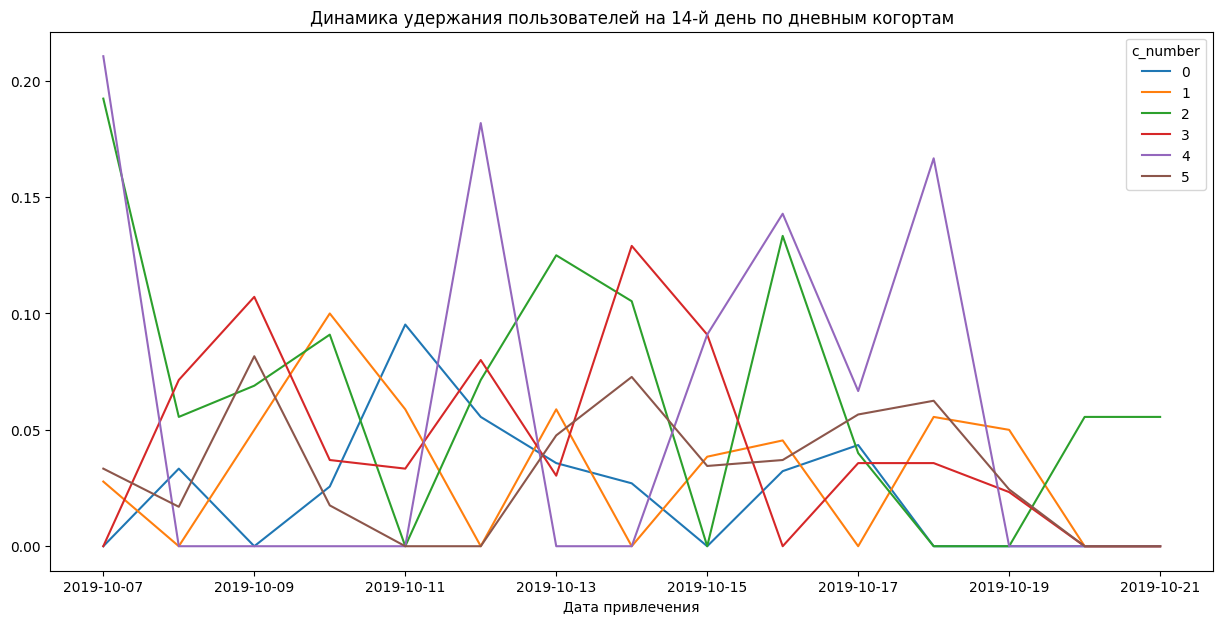

In [65]:
filtered_data = retention_history.reset_index().pivot_table(
        index='dt', columns='c_number', values=horizon_days - 1, aggfunc='mean')
filtered_data.plot(figsize=(15,7))
plt.xlabel('Дата привлечения')
plt.title('Динамика удержания пользователей на {}-й день по дневным когортам'.format(horizon_days))
plt.show()

В разрезе дневных когорт нельзя сказать, что удержание на 14-ый день формирует равномерно и сложно выявить однозначного лидера среди кластеров. Удержание заметно колеблется в зависимости от когорты. Во втором, целевом кластере фиксировался сравнительно высокий уровень удержания в начале, середине и конце анализируемого временного промежутка.

Дополнительно рассчитаем удержание с лайфтаймом в разрезе недель.

In [66]:
mdf['activate_date'] = mdf['event_time'].astype('datetime64[W]')
mdf['first_ts_w'] = mdf.groupby('user_id')['event_time'].transform('min').astype('datetime64[W]')
mdf['lifetime'] = mdf['activate_date'] - mdf['first_ts_w']

In [67]:
horizon_days = 14

last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
result_raw = mdf.query('dt <= @last_suitable_acquisition_date')
result = result_raw.pivot_table(
            index='c_number', columns='lifetime', values='user_id', aggfunc='nunique'
        )
cohort_sizes = (
           result_raw.groupby('c_number')
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
result = cohort_sizes.merge(result, on='c_number', how='left').fillna(0)
result = result.div(result['cohort_size'], axis=0)
result['cohort_size'] = cohort_sizes
result = result.drop(result.columns[1], axis= 1) 
result.style.background_gradient(cmap=cm)

,cohort_size,7 days 00:00:00,14 days 00:00:00,21 days 00:00:00,28 days 00:00:00
c_number,,,,,
0,444,0.184685,0.101351,0.038288,0.006757
1,314,0.257962,0.136943,0.060510,0.022293
2,291,0.268041,0.140893,0.085911,0.027491
3,467,0.308351,0.177730,0.070664,0.019272
4,156,0.314103,0.179487,0.121795,0.012821
5,748,0.192513,0.118984,0.034759,0.013369


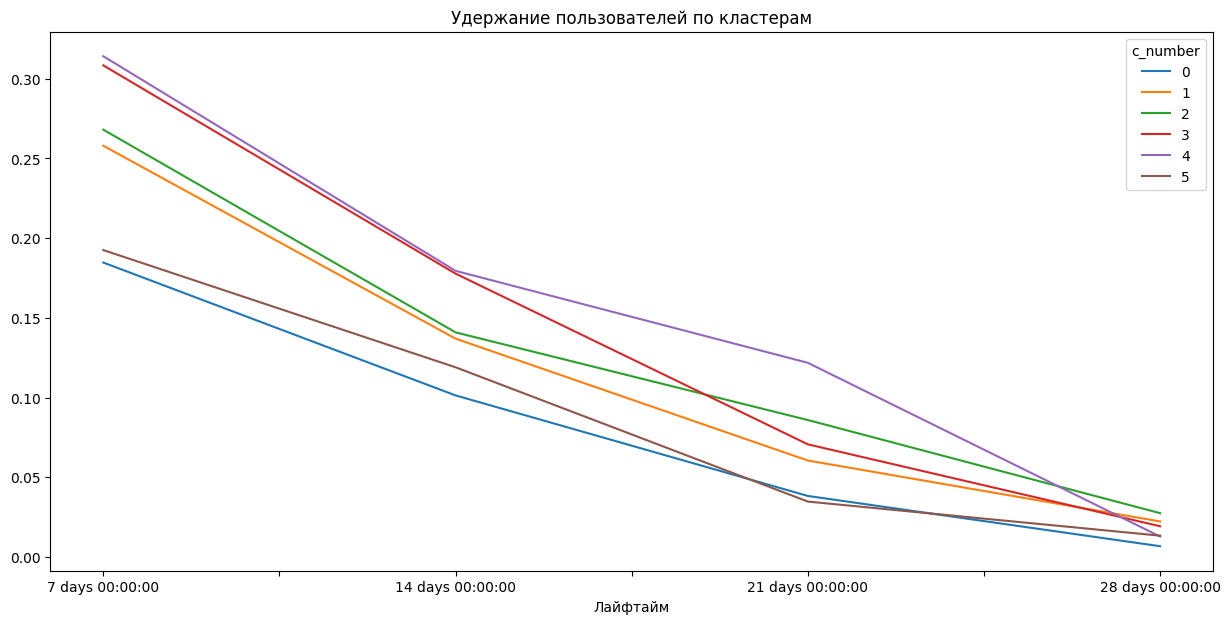

In [68]:
result.drop(columns=['cohort_size']).T.plot(figsize=(15,7))
plt.xlabel('Лайфтайм')
plt.title('Удержание пользователей по кластерам')
plt.show()

В разрезе недель на 28 день второй кластер также демонстрирует самый высокий уровень удержания.

## Расчет общей конверсии, различий кластеров по времени в приложении и проверка гипотез <a class ="anchor" id="chapter5"></a>

In [69]:
#Рассчитаем общую конверсию по кластерам
clusters_nums = []
cluster_conv_target=[]
clusters_values=[]
cluster_conv = []
conv_total = len(mdf_groupped.query('contacts_show > 0')) / len(mdf_groupped)

for i in range(0,5):
    a = len(mdf_groupped.query('c_number == @i & contacts_show > 0')) / len(mdf_groupped.query('c_number == @i'))
    b = len(mdf_groupped.query('c_number == @i & contacts_show > 0'))
    c = len(mdf_groupped.query('c_number == @i'))
    clusters_nums.append(i)
    cluster_conv_target.append(b)
    clusters_values.append(c) 
    cluster_conv.append(a)                       
    print(f' В кластере номер {i} конверсия  в целевое действие составила {a}')
print(f' Число пользователей с целевым действием по кластерам: {cluster_conv_target}')
print(f' Число пользователей в кластерах: {clusters_values}')
print(f' Общая конверсия в целевое действие по всем пользователям: {conv_total}')


 В кластере номер 0 конверсия  в целевое действие составила 0.07407407407407407
 В кластере номер 1 конверсия  в целевое действие составила 0.11636363636363636
 В кластере номер 2 конверсия  в целевое действие составила 1.0
 В кластере номер 3 конверсия  в целевое действие составила 0.24050632911392406
 В кластере номер 4 конверсия  в целевое действие составила 0.23129251700680273
 Число пользователей с целевым действием по кластерам: [48, 64, 498, 190, 68]
 Число пользователей в кластерах: [648, 550, 498, 790, 294]
 Общая конверсия в целевое действие по всем пользователям: 0.23060548722800378


Второй кластер как и ожидалось обладает максимальной конверсией в целевое действие (1), или все 498 пользователей данного кластера совершили целевое действие. Общая конверсия в целевое действие составляет 23%.

In [70]:
yandex_total = len(mdf_groupped.query('source_yandex == 1'))
yandex_target = len(mdf_groupped.query('source_yandex == 1 & contacts_show > 0'))
yandex_conv = yandex_target / yandex_total

google_total = len(mdf_groupped.query('source_google == 1'))
google_target = len(mdf_groupped.query('source_google == 1 & contacts_show > 0'))
google_conv = google_target / google_total

print(f' Конверсия по пользователям из Яндекса составляет: {yandex_conv}')
print(f' Конверсия по пользователям из Google составляет: {google_conv}')

 Конверсия по пользователям из Яндекса составляет: 0.24986876640419947
 Конверсия по пользователям из Google составляет: 0.24529991047448524


Конверсия пользователей, пришедших из Яндекса выше на **2% или менее чем на половину процентного пункта** чем у Google. При проверке гипотез о равенстве долей традиционно применяют z-тест. В нашем случае выборки достаточно велики и нет оснований полагать, что они зависимы. Поэтому применим именно данный вид теста. 

Сформулируем гипотезы:

Н0: Конверсии в целевое действие у пользователей, привлеченных с площадок yandex и google не отличаются.

Н1: Конверсии в целевое действие у пользователей, привлеченных с площадок yandex и google отличаются.

In [71]:
a_trials = yandex_total
b_trials = google_total
a_succeses = yandex_conv
b_succeses = google_conv
    
alpha = 0.05  
p1 = a_succeses/a_trials
p2 = b_succeses/b_trials
p_combined = (a_succeses + b_succeses)/ (a_trials + b_trials)
difference = p1 - p2 

z_value = difference / mth.sqrt(
p_combined * (1 - p_combined) * (1 / a_trials + 1 / b_trials))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('P-значение: ', p_value) 
    
if p_value < alpha:
            print(Fore.GREEN + Style.BRIGHT + 'Отвергаем нулевую гипотезу: между долями есть значимая разница' + Style.RESET_ALL)
else:
            print(Fore.RED + Style.BRIGHT +
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'+ Style.RESET_ALL) 

P-значение:  0.854520991831043
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты статистического теста показали, что **между конверсиями в целевое действие пользователей из Яндекса и Google** нет статистически значимой разницы.
Теперь проверим разницу конверсий с другими источниками.


Н0: Конверсии в целевое действие у пользователей, привлеченных с площадок yandex и google с одной стороны и у остальных источников не отличаются.

Н1: Конверсии в целевое действие у пользователей, привлеченных с площадок yandex и google с одной стороны и у остальных источников отличаются.


In [72]:
yandex_google_total = len(mdf_groupped.query('source_yandex == 1 | source_google  == 1'))
yandex_google_target = len(mdf_groupped.query('(source_yandex == 1 | source_google  == 1) & contacts_show > 0'))
yandex_google_conv = yandex_google_target / yandex_google_total

other_total = len(mdf_groupped.query('source_other == 1'))
other_target = len(mdf_groupped.query('source_other == 1 & contacts_show > 0'))
other_conv = other_target / other_total

print(f' Конверсия по пользователям из Яндекса и Google составляет: {yandex_google_conv}')
print(f' Конверсия по остальным пользователям составляет: {other_conv}')

 Конверсия по пользователям из Яндекса и Google составляет: 0.24818001323626737
 Конверсия по остальным пользователям составляет: 0.1865671641791045


In [73]:
a_trials = yandex_google_total
b_trials = other_total
a_succeses = yandex_google_target
b_succeses = other_target
    
alpha = 0.05  
p1 = a_succeses/a_trials
p2 = b_succeses/b_trials
p_combined = (a_succeses + b_succeses)/ (a_trials + b_trials)
difference = p1 - p2 

z_value = difference / mth.sqrt(
p_combined * (1 - p_combined) * (1 / a_trials + 1 / b_trials))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('P-значение: ', p_value) 
    
if p_value < alpha:
            print(Fore.GREEN + Style.BRIGHT + 'Отвергаем нулевую гипотезу: между долями есть значимая разница' + Style.RESET_ALL)
else:
            print(Fore.RED + Style.BRIGHT +
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'+ Style.RESET_ALL) 

P-значение:  1.7506627123520246e-05
Отвергаем нулевую гипотезу: между долями есть значимая разница



Результаты статистического теста показали, что между конверсиями в целевое действие пользователей из Яндекса и Google c одной стороны и пользователям из остальных источников есть статистически значимая разница.



Н0: Конверсии в целевое действие у пользователей, чья сессия в среднем длится менее и 1000 и более секунд не отличаются.

Н1: Конверсии в целевое действие у пользователей, чья сессия в среднем длится менее и 1000 и более секунд отличаются.

In [74]:
av_dur_more_1000_total = len(mdf_groupped.query('session_dur >= 1000 | source_google  == 1'))
av_dur_more_1000_target = len(mdf_groupped.query('session_dur >= 1000 & contacts_show > 0'))
av_dur_more_1000_conv = av_dur_more_1000_target / av_dur_more_1000_total

av_dur_less_1000_total = len(mdf_groupped.query('session_dur < 1000'))
av_dur_less_1000_target = len(mdf_groupped.query('session_dur < 1000 & contacts_show > 0'))
av_dur_less_1000_conv = av_dur_less_1000_target / av_dur_less_1000_total

print(f' Конверсия в целоевое действие у пользователей, чья сессия в среднем длится более 1000 секунд составляет: {av_dur_more_1000_conv}')
print(f' Конверсия в целоевое действие у пользователей, чья сессия в среднем длится меньше 1000 секунд составляет: {av_dur_less_1000_conv}')

 Конверсия в целоевое действие у пользователей, чья сессия в среднем длится более 1000 секунд составляет: 0.1798063623789765
 Конверсия в целоевое действие у пользователей, чья сессия в среднем длится меньше 1000 секунд составляет: 0.211420310805927


In [75]:
a_trials = av_dur_more_1000_total
b_trials = av_dur_less_1000_total
a_succeses = av_dur_more_1000_target
b_succeses = av_dur_less_1000_target
    
alpha = 0.05  
p1 = a_succeses/a_trials
p2 = b_succeses/b_trials
p_combined = (a_succeses + b_succeses)/ (a_trials + b_trials)
difference = p1 - p2 

z_value = difference / mth.sqrt(
p_combined * (1 - p_combined) * (1 / a_trials + 1 / b_trials))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('P-значение: ', p_value) 
    
if p_value < alpha:
            print(Fore.GREEN + Style.BRIGHT + 'Отвергаем нулевую гипотезу: между долями есть значимая разница' + Style.RESET_ALL)
else:
            print(Fore.RED + Style.BRIGHT +
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'+ Style.RESET_ALL)

P-значение:  0.005625836550403829
Отвергаем нулевую гипотезу: между долями есть значимая разница


Пользователи со средней длинной сессии менее 1000 секунд **показывают более высокую конверсию в целевое действие (на порядка 17%)**. Вероятно, так происходит в связи с тем, что, как как ранее установлено, многие пользователи, совершают целевое действие приходят из внешних источников сразу на нужную страницу целевого действия.

Исследуем, как различается время между распространенными событиями пользователей из разных групп.

In [76]:
time_diff_table = pd.pivot_table(mdf,index = 'user_id', columns = 'event_name', values = 'time_diff', aggfunc = 'mean').replace(0, np.nan) \
                .reset_index().merge(id_and_clusters, on = 'user_id', how='left') \
                .groupby('c_number').mean()

time_diff_table.style.background_gradient(cmap=cm)

,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show
c_number,,,,,,,,,
0,25331.554590,nan,28023.336913,52.005590,33928.360386,nan,25835.686993,46634.717045,17034.476855
1,14338.443313,nan,75851.333956,37472.921175,69119.780097,24288.123523,26344.657902,69302.730428,15532.308206
2,59726.445158,20970.135686,21246.227488,12389.914524,53084.049787,66744.096203,74434.172558,32361.025816,17514.906640
3,34338.832074,45552.279404,73469.232696,65535.605378,7312.762846,28941.844405,48069.220998,75.652224,4917.596784
4,58153.170138,73500.852361,26373.466123,19445.492628,116104.124835,16680.376858,30286.361427,29825.155199,18164.520680
5,12585.441915,55940.267933,63878.069453,74501.979100,82884.040676,54772.668179,27510.481803,7259.750953,16938.553688


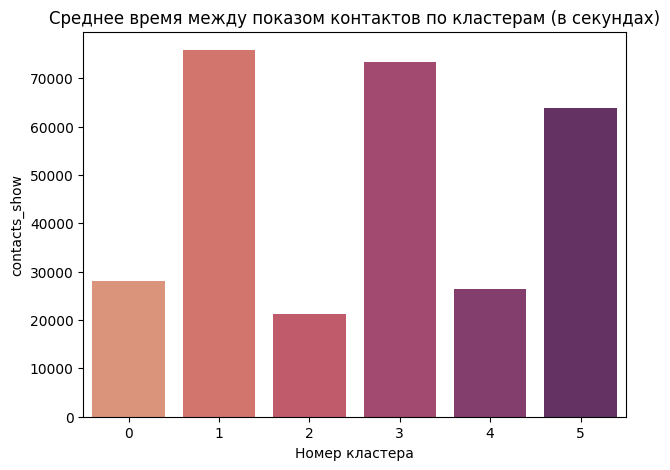

In [77]:
t = time_diff_table['contacts_show'].reset_index()
plt.figure(figsize=(7,5))
plt.title('Среднее время между показом контактов по кластерам (в секундах)')
sns.barplot(x = 'c_number', y = 'contacts_show', data=t, palette="flare")
plt.xlabel('Номер кластера')
plt.show()


**В "целевом" втором кластере самая высокая интенсивность целевого действия - просмотра контактов**. В среднем между ними проходит шесть часов, что может свидетельствовать о том, что в данной группе сосредоточены наиболее активные клиенты приложения. Так как фактическую покупку в приложении отследить сложно, можно предположить, что данные пользователи больше других покупают товары, подобранные в приложении. 

Также в целевом кластере сравнительно мало времени проходит между добавлением в избранное - три с половиной часа. При этом в данном кластере реже всего смотрят фото (один раз в 19 часов) и пользуются поиском. На этом основании можно предположить, что высокая интенсивность показов фото не означает высокую интенсивность сделок в результате пользования приложением. Похоже, те, кто открывают страницу с контактами уже знают, что им конкретно нужно и не просматривают фото, а сразу коммуницируют с продавцом.

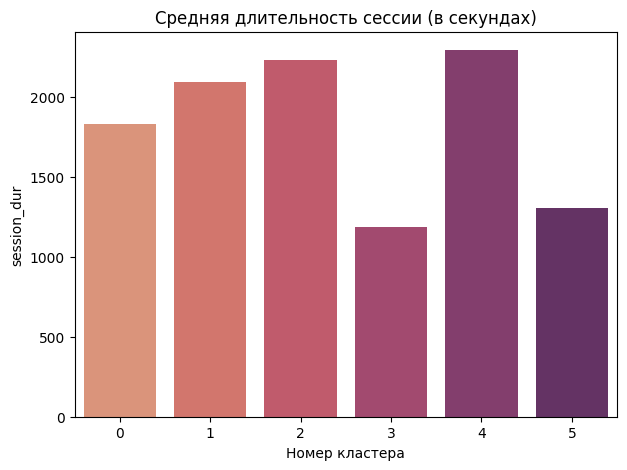

In [78]:
time_in_app = mdf.groupby('c_number')['session_dur'].mean().reset_index()
plt.figure(figsize=(7,5))
plt.title('Средняя длительность сессии (в секундах)')
sns.barplot(x = 'c_number', y = 'session_dur', data=time_in_app, palette="flare")
plt.xlabel('Номер кластера')
plt.show()

Кластеры номер два (целевой) и номер четыре показывают сравнительно высокую среднюю длительность сессии. **В целевом кластере высокая длительность нахождения в приложении, вероятно, объясняется высокой мотивированностью пользователей совершить покупку (так как в данном кластере клиенты интенсивнее и больше других просматривают контакты)**. В четвертый же кластер отличается высокой интенсивностью просмотра фото и, возможно, в нем сконцентрированы в том числе не реальные покупатели, а те, кто просто просматривает фото товаров в развлекательных целях, не имея реальной возможности совершить сделку.

## Общие выводы <a class ="anchor" id="chapter6"></a>

1. В рамках предобработки данных уточнены названия полей, объединены все виды поиска в один для облегчения анализа, ликвидировано 'задвоение' целевого события contacts_show. Также поле event_time приведено к временному типу данных. Пропусков и дубликатов в загруженных датасетах не обнаружено.

2. Конкретного дня недели, для которого был характерен пик по всем событиям нет. Однако **если говорить о целевом событии contacts_show, то оно характерно для понедельника-четверга, а ближе к выходным заметен большой спад**. То же можно сказать и о звонках по объявлениям. При этом пик просмотров фото в объявлениях приходится на выходные, тогда же люди активно добавляют в избранное и пользуются поиском.

3. Целевое событие contacts_show является пятым по частотности событием на анализируемом отрезке времени. Самое "популярное" tips_show, однако число tips_click  сравнительно мало. Поэтому построение воронки по всем видам событий в данном случае лишено смысла. При этом можно констатировать, что **в среднем на одно открытие объявления приходится показ 1.6 фотографий, 0.73 показа контактов и 0.088 звонков**.

4. У медианного пользователя приложения в анализируемом периоде была **всего одна сессия, при этом ни разу не открывал поиск, не добавлял в избранное, не открывал страницу объявления и не просматривал контакты. В основном его действия набирались за счет предложения объявлений, то есть не зависящих от пользователя событий**. На 45% поток пользователей формировался за счет Яндекса, на 29% за счет прочих источников и 26% приходили по каналам Google. 


5. Пользователи второго кластера значительно меньше добавляют объявления в избранное, открывают сообщения и пользуются поиском. При этом совершают значительно больше звонков по показанным контактам. 

6. **Большинство (половина) целевых событий contacts_show происходят после такого же события**. Также значителен объем "переходов" из contacts_call и photos_show. При этом прямых переходов из открытия объявления в показ контактов в значимых объемах нет. **Вероятно, это обусловлено спецификой использования сервиса, когда пользователь открывает сразу много объявлений в разных вкладках и потом "открывает" контакты после звонка в предыдущей вкладке или просмотра фото. Но чаще всего просто переходит в новую вкладку и, не просматривая фото дополнительно, открывает контакты**. 

7. **Показ контакта имеет максимальную долю среди всех событий на первом шаге. Это, видимо, объясняется тем, что пользователи в значительном объеме попадают на экран открытия контактов по прямой внешней ссылке, минуя экраны поиска, карты объявлений и самой карточки объявления**. Впрочем, для большинства пользователей сервиса первым шагом является поиск, карта объявлений и просмотр фото (на страницу также, вероятно, попадают по прямой ссылке). С каждым последующим шагом пользователей доля открытия контактов плавно снижается. Она наиболее велика во время первых шести шагов.

8. **В "просмотр контактов" основная масса пользователей попадает не из приложения - у 38% из тех, у кого было открытие контактов, не было предыдущего события внутри приложения**. 19% в предыдущем действии просматривали фото, 16% - поиск и 15% - карту объявлений. Чаще всего просмотрев контакты пользователь уходит в новый просмотр контактов (38%), или уходит из приложения не позвонив (17%) или звонит (13%). Впрочем, вероятно, низкая конверсия в звонок связана с тем, что приложение не может отследить звонок по внешнему устройству и реальная конверсия выше. **Поэтому конверсию в звонок следует анализировать с осторожностью**.

9. **В "целевом" кластере велика доля посетителей, пришедших из "Яндекса" (50%), что дает основания полагать, что именно оттуда в первую очередь приходят пользователи по внешним ссылкам сразу на целевое действие**. 

10. Во втором "целевом" кластере  наблюдается максимальный уровень удержания клиентов, затем он усредняется с другими кластерами но к 14-му дню вновь выходит на первое место на уровне порядка 7,5%. Таким образом, группа с максимальным средним показателем совершения целевого действия обладает максимальным уровнем удержания. 

11. В разрезе дневных когорт нельзя сказать, что удержание на 14-ый день формирует равномерно и сложно выявить однозначного лидера среди кластеров. Удержание заметно колеблется в зависимости от когорты. Во втором, целевом кластере фиксировался сравнительно высокий уровень удержания в начале, середине и конце анализируемого временного промежутка. В разрезе недельных когорт на 28 день второй кластер также демонстрирует самый высокий уровень удержания. Кроме того, **целевая группа обладает максимальной конверсией в целевое действие (1), или все 498 пользователей данного кластера совершили целевое действие. Общая конверсия всех пользователей в целевое действие составляет 23%**.

12. Конверсия пользователей, пришедших из Яндекса выше на **2% или менее чем на половину процентного пункта** чем у Google. Как показывает статистический тест она **не является статистически значимой**.

13. Разница между конверсиями в целевое действие между пользователями Яндекса и Google c одной стороны и пользователям из остальных источников составляет порядка 30%. Тест показывает статистическую значимость даного отличия. 

14. **Пользователи со средней длинной сессии менее 1000 секунд показывают более высокую конверсию в целевое действие (на порядка 17%)**. Вероятно, так происходит в связи с тем, что, многие пользователи, совершают целевое действие приходя из внешних источников сразу на нужную страницу целевого действия.

15. В "целевом" втором кластере самая высокая интенсивность целевого действия - просмотра контактов. В среднем между ними проходит шесть часов, что может свидетельствовать о том, что в данной группе сосредоточены наиболее активные клиенты приложения. Так как фактическую покупку в приложении отследить сложно, можно предположить, что данные пользователи больше других покупают товары, подобранные в приложении. При этом в данном кластере реже всего смотрят фото (один раз в 19 часов) и пользуются поиском. На этом основании можно предположить, что высокая интенсивность показов фото не означает высокую интенсивность сделок в результате пользования приложением.

16. Кластеры номер два (целевой) и номер четыре показывают сравнительно высокую среднюю длительность сессии. **В целевом кластере высокая длительность нахождения в приложении, вероятно, объясняется высокой мотивированностью пользователей совершить покупку (так как в данном кластере клиенты интенсивнее и больше других просматривают контакты)**. В четвертый же кластер отличается высокой интенсивностью просмотра фото и, возможно, в нем сконцентрированы в том числе не реальные покупатели, а те, кто просто просматривает фото товаров в развлекательных целях, не имея реальной возможности совершить сделку.

**Рекомендации:**

1. При привлечении пользователей через рекламу желательно отдавать предпочтение рекламным системам Яндекс и Google. У них значительно выше конверсия в целевое действие, чем у иных источников. 

2. Не стоит акцентировать маркетинговую активность на пользователях, которые демонстрируют высокую интенсивность просмотров фото. Они не демонстрируют высокой конверсии в целевое действие. Целевое событие - просмотр контактов - пользователи совершают чаще всего именно после просмотра других контактов. **Просмотр контакт означает, что человек реально готов к покупке и ему можно интенсивно предлагать дополнительные товары из данной товарной категории**. 

3. Целевое действие совершается в основном в середине недели и часто оказывается первым действием в приложении, поэтому не рекомендуется активно вкладываться в привлечение трафика по выходным. 

4. Длинные сессии не нужно воспринимать как признак качества аудитории. Конверсия в целевое действие у пользователей со средней длинной сессии менее 1000 секунд выше, чем у пользователей с более длинными сессиями. 

5. После целевого действия пользователи почти не совершают действий по открытию новых объявлений и не кликают на рекомендованные предложения. Необходимо усовершенствовать рекомендательную систему, чтобы нарастить процент соответствующих действие и повысить удержание клиентов.

